This notebook implements model training, evaluation and hyperparameter tuning for DistilBERT on the *raw* dataset. It also draws insights from Ingle et al. (2022), who explored partial fine-tuning of RoBERTa for training stability. However, they did not investigate whether similar strategies benefit other transformer models such as DistilBERT.

**Addressing Limitations:**

In this notebook,their approach was adapted by freezing all but the final two transformer layers in DistilBERT. This adaptation aims to improve training stability on noisy, informal tweet data, supporting the generalizability of their findings to lightweight transformer variants.

**Reference:**

Ingle, D., Tripathi, R., Kumar, A., Patel, K., & Vepa, J. (2022). Investigating the characteristics of a transformer in a few-shot setup: Does freezing layers in RoBERTa help? *Proceedings of the Fifth BlackboxNLP Workshop on Analyzing and Interpreting Neural Networks for NLP*, 238–248. https://doi.org/10.18653/v1/2022.blackboxnlp-1.19

---
# **Install & Import Required Libraries**

In [ ]:
# Install required Python libraries for model training and data handling
!pip install torch transformers datasets optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna.visualization as vis
import optuna
import shutil
import os
import json

from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments,  AutoModel, AutoConfig, set_seed
from datasets import Dataset
from transformers import EarlyStoppingCallback

set_seed(42)

---
# **1. Data Splitting**

## Load Dataset

In [ ]:
# Load dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/dataset.csv"
columns = ["label", "tweet"]
df = pd.read_csv(data_path, header = None, names = columns)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   tweet   100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                              tweet
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all.... 

label
0    50000
1    50000
Name: count, dtype: int64


## Train-Test Split (80%-20%)

In [ ]:
# 80%-20% Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    df["tweet"],          # Use raw tweet text
    df["label"],          # Corresponding sentiment labels
    test_size=0.2,        # 20% test set reserved for final evaluation
    random_state=42,      # Ensures reproducibility
    stratify=df["label"]  # Maintains the same proportion of labels in train & test
)

---
# **2. Feature Engineering**

## Load Tokenizer

In [ ]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## Helper Functions:

### Tokenize the dataset

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],        # The column that will be tokenized
        truncation=True,         # Cuts off sequences longer than max_length
        padding="max_length",    # Pads shorter sequences to max_length
        max_length=128           # Max token length
    )

### Convert data to Hugging Face dataset format & apply tokenization

In [ ]:
def prepare_dataset(texts, labels):
    '''
    Converts raw texts and labels into a pandas.DataFrame.
    Converts the DataFrame into a Hugging Face Dataset.
    Applies the tokenize_function (defined earlier) to tokenize all entries.
        - When passing data to a Trainer, Hugging Face expects only the necessary inputs:
        - 'input_ids', 'attention_mask', and optionally 'label'
        - Remove "text" & "__index_level_0__" columns that the model won't use
        - The Trainer (and the model) by default expects a column named "labels".
    '''
    df = pd.DataFrame({"text": texts, "label": labels})
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize_function, batched=True).remove_columns(set(dataset.column_names) - {"input_ids", "attention_mask", "label"})
    dataset = dataset.rename_column("label", "labels")
    return dataset

---
# **3.1 Initial Model Training**

## Define Training Arguments

In [ ]:
# Training Arguments for GPU
def create_training_args(model_loader):
    return TrainingArguments(
        output_dir=f"./results_{model_loader.__name__}", # Directory to store checkpoints
        report_to="none",                                # Disable WandB logging
        eval_strategy="epoch",                           # Evaluate after each epoch
        save_strategy="epoch",                           # Save checkpoints each epoch
        per_device_train_batch_size=8,                   # Referenced from Pota et al. (2021)
        per_device_eval_batch_size=8,                    # Same as train batch size for consistency
        num_train_epochs=5,                              # Referenced from Pota et al. (2021)
        learning_rate=3e-5,                              # Referenced from Pota et al. (2021)
        weight_decay=0.01,                               # Prevents overfitting by penalizing large weights
        fp16=True,                                       # Enable mixed precision for faster training on GPU
        gradient_accumulation_steps=16,                  # Accumulate gradients to simulate larger batch size (Pota et al., 2021)
        logging_dir=f"./logs_{model_loader.__name__}",   # Directory for logging training metrics
        logging_strategy="epoch",                        # Log training loss once per epoch
        load_best_model_at_end=True,                     # Important for early stopping
        metric_for_best_model="eval_f1",                 # Use F1-score to determine the best model
        greater_is_better=True,                          # Higher F1 is better (for early stopping and best model logic)
        seed=42                                          # Ensures reproducibility
    )

## Custom Model Architecture

In [ ]:
class CustomDistilBERTClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-cased", num_labels=2,
                 hidden_units=[256, 64], dropout_rate=0.3, activation=nn.ReLU):
        super().__init__()

        # Load DistilBERT (without classification head)
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze all layers first
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last 2 transformer layers (DistilBERT has 6 layers)
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Build custom classification head dynamically
        layers = []
        input_size = self.bert.config.hidden_size  # Typically 768

        for hidden_size in hidden_units:
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_labels))
        self.classifier = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get [CLS] token embedding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        logits = self.classifier(cls_output)

        # Hugging Face Trainer expects a dict with loss + logits
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

## Helper Functions for Fold-running:

### Load model

In [ ]:
def load_pretrained_model():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

In [ ]:
def load_custom_model(hidden_units=None, dropout_rate=None, activation=None):
    return CustomDistilBERTClassifier(
        "distilbert-base-cased",
        num_labels=2,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation
    )

### Extract loss histories from the training logs


In [ ]:
def extract_loss_history(log_history):
    # Extract training and evaluation loss histories from log_history
    train_loss_history = [log["loss"] for log in log_history if "loss" in log]
    val_loss_history = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    return train_loss_history, val_loss_history

### Extract evaluation logs from log history and compute the average for each evaluation metric across epochs

In [ ]:
def get_average_epoch_metrics(log_history):
    # Filter logs that include evaluation metrics
    eval_entries = [entry for entry in log_history if "eval_loss" in entry]
    if not eval_entries:
        return {}

    # Get all keys that start with 'eval_'
    metric_keys = [key for key in eval_entries[0].keys() if key.startswith("eval_")]

    avg_metrics = {}
    for key in metric_keys:
        # Compute the average of this metric across all evaluation entries (typically 3 epochs)
        avg_metrics[key] = np.mean([entry[key] for entry in eval_entries])

    return avg_metrics

### Print summary of a fold's results

In [ ]:
def print_fold_summary(fold, avg_epoch_metrics,
                       train_loss_history, val_loss_history,
                       avg_train_loss, avg_eval_loss):

    # Print a formatted summary for a training fold

    print(f"\nFold {fold + 1} Summary")
    print("-" * 50)
    print("\nAverage Metrics Across Epochs:")
    for k, v in avg_epoch_metrics.items():
        print(f"{k:<25}: {v:.4f}")

    print("\nLoss History:")
    print(f"- Training Loss per Epoch   : {[f'{l:.4f}' for l in train_loss_history]}")
    print(f"- Validation Loss per Epoch : {[f'{l:.4f}' for l in val_loss_history]}")
    print(f"- Average Training Loss     : {avg_train_loss:.4f}")
    print(f"- Average Validation Loss   : {avg_eval_loss:.4f}")
    print("=" * 60)

### Define evaluation metrics: accuracy, precision, recall & F1 score

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## Main Function to Run a Single Fold

In [ ]:
def run_fold(fold, train_texts, train_labels, val_texts, val_labels, training_args, model_loader):
    # Prepare tokenized datasets for training and validation
    train_dataset = prepare_dataset(train_texts, train_labels)
    val_dataset = prepare_dataset(val_texts, val_labels)

    # Load the model and move it to GPU
    model = model_loader()
    model.to(device)

    # Initialize the Trainer with compute_metrics and an early stopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train() # Train the model on the current fold
    log_history = trainer.state.log_history # Retrieve training log history
    train_loss_history, val_loss_history = extract_loss_history(log_history) # Extract loss histories
    avg_epoch_metrics = get_average_epoch_metrics(log_history) # Compute average evaluation metrics

    # Compute average losses across epochs
    avg_train_loss = np.mean(train_loss_history) if train_loss_history else None
    avg_eval_loss = np.mean(val_loss_history) if val_loss_history else None

    # Print a summary of results for this fold
    print_fold_summary(fold, avg_epoch_metrics, train_loss_history, val_loss_history, avg_train_loss, avg_eval_loss)

    return {
        "avg_epoch_metrics": avg_epoch_metrics, # average evaluation metrics across all epochs
        "train_loss_history": train_loss_history, # training loss history
        "val_loss_history": val_loss_history, # validation loss history
        "avg_train_loss": avg_train_loss, # average training loss across all epochs
        "avg_eval_loss": avg_eval_loss, # average validation loss across all epochs
        "log_history": trainer.state.log_history
    }

## Check GPU Availability

In [ ]:
# Set up GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")  # Should print "cuda" if GPU is available

Using device: cuda


## Perform 5-Fold Cross-Validation on the Training Set

In [ ]:
def run_cross_validation(x_train, y_train, training_args, model_loader, k = 5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/{k}")

        # Split training data into 80% train, 20% validation for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate the fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)
        fold_results.append(result)

    return fold_results

**WARNING**: Running the below code chunk will take approximately 1 hour on GPU

In [ ]:
model_loader = load_pretrained_model
training_args = create_training_args(model_loader)
fold_results_pretrained_model = run_cross_validation(x_train, y_train, training_args, model_loader)


Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.430700,0.382972,0.828750,0.828755,0.828750,0.828749
2,0.324900,0.393869,0.829875,0.830280,0.829875,0.829823
3,0.247400,0.424255,0.832750,0.832753,0.832750,0.832750
4,0.182300,0.479043,0.827500,0.827830,0.827500,0.827457
5,0.139000,0.542669,0.827562,0.827563,0.827562,0.827562



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4446
eval_accuracy            : 0.8293
eval_precision           : 0.8294
eval_recall              : 0.8293
eval_f1                  : 0.8293
eval_runtime             : 17.0782
eval_samples_per_second  : 936.8784
eval_steps_per_second    : 117.1100

Loss History:
- Training Loss per Epoch   : ['0.4307', '0.3249', '0.2474', '0.1823', '0.1390']
- Validation Loss per Epoch : ['0.3830', '0.3939', '0.4243', '0.4790', '0.5427']
- Average Training Loss     : 0.2649
- Average Validation Loss   : 0.4446

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432100,0.387246,0.826250,0.830046,0.826250,0.825749
2,0.325600,0.383870,0.833187,0.834585,0.833187,0.833013
3,0.246700,0.425687,0.831500,0.831650,0.831500,0.831481
4,0.181000,0.480422,0.827313,0.827764,0.827313,0.827253



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4193
eval_accuracy            : 0.8296
eval_precision           : 0.8310
eval_recall              : 0.8296
eval_f1                  : 0.8294
eval_runtime             : 17.2637
eval_samples_per_second  : 926.8052
eval_steps_per_second    : 115.8507

Loss History:
- Training Loss per Epoch   : ['0.4321', '0.3256', '0.2467', '0.1810']
- Validation Loss per Epoch : ['0.3872', '0.3839', '0.4257', '0.4804']
- Average Training Loss     : 0.2964
- Average Validation Loss   : 0.4193

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.433500,0.380561,0.830688,0.832851,0.830688,0.830412
2,0.329300,0.386866,0.835750,0.837321,0.835750,0.835559
3,0.246600,0.412095,0.836313,0.836841,0.836313,0.836248
4,0.180600,0.465869,0.831812,0.831814,0.831812,0.831812
5,0.141200,0.521804,0.832438,0.832464,0.832438,0.832434



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4334
eval_accuracy            : 0.8334
eval_precision           : 0.8343
eval_recall              : 0.8334
eval_f1                  : 0.8333
eval_runtime             : 17.2106
eval_samples_per_second  : 929.6766
eval_steps_per_second    : 116.2096

Loss History:
- Training Loss per Epoch   : ['0.4335', '0.3293', '0.2466', '0.1806', '0.1412']
- Validation Loss per Epoch : ['0.3806', '0.3869', '0.4121', '0.4659', '0.5218']
- Average Training Loss     : 0.2662
- Average Validation Loss   : 0.4334

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432400,0.386112,0.828375,0.829694,0.828375,0.828203
2,0.326300,0.376325,0.838250,0.838379,0.838250,0.838235
3,0.246200,0.424428,0.834063,0.834562,0.834063,0.834001
4,0.180900,0.467612,0.829875,0.830903,0.829875,0.829743



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4136
eval_accuracy            : 0.8326
eval_precision           : 0.8334
eval_recall              : 0.8326
eval_f1                  : 0.8325
eval_runtime             : 17.1344
eval_samples_per_second  : 933.8230
eval_steps_per_second    : 116.7280

Loss History:
- Training Loss per Epoch   : ['0.4324', '0.3263', '0.2462', '0.1809']
- Validation Loss per Epoch : ['0.3861', '0.3763', '0.4244', '0.4676']
- Average Training Loss     : 0.2964
- Average Validation Loss   : 0.4136

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.430700,0.388217,0.828875,0.828962,0.828875,0.828864
2,0.325400,0.380922,0.833375,0.833402,0.833375,0.833372
3,0.246200,0.429312,0.828562,0.828683,0.828562,0.828547
4,0.179700,0.485496,0.828187,0.828395,0.828187,0.828160



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4210
eval_accuracy            : 0.8297
eval_precision           : 0.8299
eval_recall              : 0.8297
eval_f1                  : 0.8297
eval_runtime             : 17.5475
eval_samples_per_second  : 912.1553
eval_steps_per_second    : 114.0195

Loss History:
- Training Loss per Epoch   : ['0.4307', '0.3254', '0.2462', '0.1797']
- Validation Loss per Epoch : ['0.3882', '0.3809', '0.4293', '0.4855']
- Average Training Loss     : 0.2955
- Average Validation Loss   : 0.4210


**WARNING**: Running the below code chunk will take approximately 5 hours on GPU

In [ ]:
# Define architecture experiments
experiments = [
    {"name": "baseline", "hidden_units": [256]},
    {"name": "medium", "hidden_units": [256, 64]},
    {"name": "deep", "hidden_units": [512, 256, 64]},
    {"name": "wide", "hidden_units": [512]},
    {"name": "shallow", "hidden_units": [64]},
]

# Dictionary to store results
fold_results_custom_model = {}

# Loop over each architecture
for exp in experiments:
    print(f"\nRunning Experiment: {exp['name']} | Architecture: {exp['hidden_units']}")

    # Wrap load_custom_model to pass parameters
    model_loader = lambda: load_custom_model(
        hidden_units=exp["hidden_units"],
        dropout_rate=0.3,             # You can also vary this if needed
        activation=nn.ReLU            # Try nn.GELU or nn.Tanh for other runs
    )

    # Create training arguments
    training_args = create_training_args(model_loader)

    # Run 5-fold cross-validation
    fold_results = run_cross_validation(x_train, y_train, training_args, model_loader)

    # Save results under experiment name
    fold_results_custom_model[exp["name"]] = fold_results


Running Experiment: baseline | Architecture: [256]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484100,0.429677,0.804375,0.804455,0.804375,0.804362
2,0.422800,0.412938,0.813375,0.813463,0.813375,0.813362
3,0.396100,0.407809,0.818000,0.818137,0.818000,0.817980
4,0.378300,0.403598,0.818312,0.818569,0.818312,0.818276
5,0.364600,0.407877,0.820000,0.820039,0.820000,0.819995



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4124
eval_accuracy            : 0.8148
eval_precision           : 0.8149
eval_recall              : 0.8148
eval_f1                  : 0.8148
eval_runtime             : 17.2355
eval_samples_per_second  : 928.3242
eval_steps_per_second    : 116.0404

Loss History:
- Training Loss per Epoch   : ['0.4841', '0.4228', '0.3961', '0.3783', '0.3646']
- Validation Loss per Epoch : ['0.4297', '0.4129', '0.4078', '0.4036', '0.4079']
- Average Training Loss     : 0.4092
- Average Validation Loss   : 0.4124

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484700,0.432766,0.799125,0.800619,0.799125,0.798875
2,0.423400,0.414882,0.810375,0.811040,0.810375,0.810274
3,0.397300,0.406236,0.815625,0.815778,0.815625,0.815603
4,0.377200,0.406255,0.817625,0.817625,0.817625,0.817625
5,0.363300,0.408973,0.819937,0.819957,0.819937,0.819935



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4138
eval_accuracy            : 0.8125
eval_precision           : 0.8130
eval_recall              : 0.8125
eval_f1                  : 0.8125
eval_runtime             : 17.2249
eval_samples_per_second  : 928.8944
eval_steps_per_second    : 116.1118

Loss History:
- Training Loss per Epoch   : ['0.4847', '0.4234', '0.3973', '0.3772', '0.3633']
- Validation Loss per Epoch : ['0.4328', '0.4149', '0.4062', '0.4063', '0.4090']
- Average Training Loss     : 0.4092
- Average Validation Loss   : 0.4138

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488200,0.427867,0.804063,0.804064,0.804063,0.804062
2,0.427600,0.410524,0.812688,0.813074,0.812688,0.812630
3,0.399500,0.404869,0.819500,0.820635,0.819500,0.819340
4,0.379700,0.400221,0.821812,0.821841,0.821812,0.821809
5,0.368000,0.400312,0.823375,0.823380,0.823375,0.823374



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4088
eval_accuracy            : 0.8163
eval_precision           : 0.8166
eval_recall              : 0.8163
eval_f1                  : 0.8162
eval_runtime             : 17.2413
eval_samples_per_second  : 928.0342
eval_steps_per_second    : 116.0044

Loss History:
- Training Loss per Epoch   : ['0.4882', '0.4276', '0.3995', '0.3797', '0.3680']
- Validation Loss per Epoch : ['0.4279', '0.4105', '0.4049', '0.4002', '0.4003']
- Average Training Loss     : 0.4126
- Average Validation Loss   : 0.4088

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485300,0.440580,0.794312,0.798975,0.794312,0.793508
2,0.421100,0.416707,0.807438,0.807490,0.807438,0.807429
3,0.393100,0.416044,0.811625,0.811970,0.811625,0.811573
4,0.376000,0.410552,0.814000,0.814413,0.814000,0.813939
5,0.360600,0.413071,0.813000,0.813038,0.813000,0.812994



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4194
eval_accuracy            : 0.8081
eval_precision           : 0.8092
eval_recall              : 0.8081
eval_f1                  : 0.8079
eval_runtime             : 17.1974
eval_samples_per_second  : 930.3792
eval_steps_per_second    : 116.2974

Loss History:
- Training Loss per Epoch   : ['0.4853', '0.4211', '0.3931', '0.3760', '0.3606']
- Validation Loss per Epoch : ['0.4406', '0.4167', '0.4160', '0.4106', '0.4131']
- Average Training Loss     : 0.4072
- Average Validation Loss   : 0.4194

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482200,0.440644,0.794937,0.795323,0.794937,0.794871
2,0.421100,0.418336,0.809375,0.809423,0.809375,0.809368
3,0.395200,0.414728,0.814625,0.814626,0.814625,0.814625
4,0.376500,0.413692,0.814937,0.814951,0.814937,0.814935
5,0.363000,0.417060,0.815375,0.815538,0.815375,0.815351



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4209
eval_accuracy            : 0.8098
eval_precision           : 0.8100
eval_recall              : 0.8098
eval_f1                  : 0.8098
eval_runtime             : 17.2395
eval_samples_per_second  : 928.1160
eval_steps_per_second    : 116.0144

Loss History:
- Training Loss per Epoch   : ['0.4822', '0.4211', '0.3952', '0.3765', '0.3630']
- Validation Loss per Epoch : ['0.4406', '0.4183', '0.4147', '0.4137', '0.4171']
- Average Training Loss     : 0.4076
- Average Validation Loss   : 0.4209

Running Experiment: medium | Architecture: [256, 64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498000,0.435367,0.802375,0.802443,0.802375,0.802364
2,0.428600,0.418751,0.813000,0.813389,0.813000,0.812942
3,0.401700,0.410296,0.816813,0.816822,0.816813,0.816811
4,0.383900,0.408242,0.816562,0.816603,0.816562,0.816557
5,0.371500,0.411067,0.817250,0.817304,0.817250,0.817242



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4167
eval_accuracy            : 0.8132
eval_precision           : 0.8133
eval_recall              : 0.8132
eval_f1                  : 0.8132
eval_runtime             : 17.4413
eval_samples_per_second  : 917.3706
eval_steps_per_second    : 114.6714

Loss History:
- Training Loss per Epoch   : ['0.4980', '0.4286', '0.4017', '0.3839', '0.3715']
- Validation Loss per Epoch : ['0.4354', '0.4188', '0.4103', '0.4082', '0.4111']
- Average Training Loss     : 0.4167
- Average Validation Loss   : 0.4167

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.496600,0.436104,0.797875,0.800056,0.797875,0.797507
2,0.429500,0.419829,0.809750,0.810400,0.809750,0.809650
3,0.402700,0.408275,0.817312,0.817313,0.817312,0.817312
4,0.383200,0.407929,0.819750,0.819758,0.819750,0.819749
5,0.369200,0.411572,0.820063,0.820095,0.820063,0.820058



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4167
eval_accuracy            : 0.8130
eval_precision           : 0.8135
eval_recall              : 0.8130
eval_f1                  : 0.8129
eval_runtime             : 17.3879
eval_samples_per_second  : 920.1838
eval_steps_per_second    : 115.0232

Loss History:
- Training Loss per Epoch   : ['0.4966', '0.4295', '0.4027', '0.3832', '0.3692']
- Validation Loss per Epoch : ['0.4361', '0.4198', '0.4083', '0.4079', '0.4116']
- Average Training Loss     : 0.4162
- Average Validation Loss   : 0.4167

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.500900,0.433762,0.799625,0.800800,0.799625,0.799429
2,0.430100,0.411792,0.814438,0.814559,0.814438,0.814420
3,0.401100,0.405892,0.819500,0.819778,0.819500,0.819461
4,0.383300,0.401710,0.821438,0.821502,0.821438,0.821429
5,0.369300,0.403286,0.822063,0.822066,0.822063,0.822062



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4113
eval_accuracy            : 0.8154
eval_precision           : 0.8157
eval_recall              : 0.8154
eval_f1                  : 0.8154
eval_runtime             : 17.5147
eval_samples_per_second  : 913.5606
eval_steps_per_second    : 114.1950

Loss History:
- Training Loss per Epoch   : ['0.5009', '0.4301', '0.4011', '0.3833', '0.3693']
- Validation Loss per Epoch : ['0.4338', '0.4118', '0.4059', '0.4017', '0.4033']
- Average Training Loss     : 0.4169
- Average Validation Loss   : 0.4113

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.496500,0.445261,0.794438,0.799235,0.794438,0.793610
2,0.428000,0.420659,0.807312,0.807313,0.807312,0.807312
3,0.402600,0.417875,0.811688,0.812030,0.811688,0.811636
4,0.383200,0.413222,0.811813,0.812507,0.811813,0.811708
5,0.369700,0.414276,0.811813,0.811896,0.811813,0.811800



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4223
eval_accuracy            : 0.8074
eval_precision           : 0.8086
eval_recall              : 0.8074
eval_f1                  : 0.8072
eval_runtime             : 17.5495
eval_samples_per_second  : 911.7576
eval_steps_per_second    : 113.9698

Loss History:
- Training Loss per Epoch   : ['0.4965', '0.4280', '0.4026', '0.3832', '0.3697']
- Validation Loss per Epoch : ['0.4453', '0.4207', '0.4179', '0.4132', '0.4143']
- Average Training Loss     : 0.4160
- Average Validation Loss   : 0.4223

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.495300,0.445369,0.795375,0.795885,0.795375,0.795287
2,0.426400,0.423204,0.806688,0.806693,0.806688,0.806687
3,0.398800,0.421173,0.812562,0.812756,0.812562,0.812534
4,0.380700,0.419213,0.814250,0.814273,0.814250,0.814247
5,0.368500,0.420611,0.814813,0.814988,0.814813,0.814787



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4259
eval_accuracy            : 0.8087
eval_precision           : 0.8089
eval_recall              : 0.8087
eval_f1                  : 0.8087
eval_runtime             : 17.4729
eval_samples_per_second  : 915.7120
eval_steps_per_second    : 114.4640

Loss History:
- Training Loss per Epoch   : ['0.4953', '0.4264', '0.3988', '0.3807', '0.3685']
- Validation Loss per Epoch : ['0.4454', '0.4232', '0.4212', '0.4192', '0.4206']
- Average Training Loss     : 0.4139
- Average Validation Loss   : 0.4259

Running Experiment: deep | Architecture: [512, 256, 64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.503600,0.434562,0.802312,0.802316,0.802312,0.802312
2,0.428600,0.416417,0.812937,0.812959,0.812937,0.812934
3,0.402700,0.409809,0.818937,0.818957,0.818937,0.818935
4,0.382100,0.409798,0.818375,0.818788,0.818375,0.818316
5,0.369900,0.412902,0.820937,0.820956,0.820937,0.820935



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4167
eval_accuracy            : 0.8147
eval_precision           : 0.8148
eval_recall              : 0.8147
eval_f1                  : 0.8147
eval_runtime             : 17.7630
eval_samples_per_second  : 900.7596
eval_steps_per_second    : 112.5950

Loss History:
- Training Loss per Epoch   : ['0.5036', '0.4286', '0.4027', '0.3821', '0.3699']
- Validation Loss per Epoch : ['0.4346', '0.4164', '0.4098', '0.4098', '0.4129']
- Average Training Loss     : 0.4174
- Average Validation Loss   : 0.4167

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.506800,0.435500,0.797375,0.798798,0.797375,0.797134
2,0.431200,0.420187,0.810125,0.810505,0.810125,0.810067
3,0.403900,0.411141,0.814688,0.814691,0.814688,0.814687
4,0.384700,0.410878,0.818187,0.818190,0.818187,0.818187
5,0.371000,0.413095,0.817813,0.817816,0.817813,0.817812



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4182
eval_accuracy            : 0.8116
eval_precision           : 0.8120
eval_recall              : 0.8116
eval_f1                  : 0.8116
eval_runtime             : 17.7518
eval_samples_per_second  : 901.3366
eval_steps_per_second    : 112.6670

Loss History:
- Training Loss per Epoch   : ['0.5068', '0.4312', '0.4039', '0.3847', '0.3710']
- Validation Loss per Epoch : ['0.4355', '0.4202', '0.4111', '0.4109', '0.4131']
- Average Training Loss     : 0.4195
- Average Validation Loss   : 0.4182

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.509700,0.430319,0.803375,0.803496,0.803375,0.803355
2,0.431800,0.412888,0.814250,0.814309,0.814250,0.814241
3,0.403200,0.404844,0.817625,0.817683,0.817625,0.817617
4,0.385000,0.405177,0.818625,0.818889,0.818625,0.818588
5,0.371500,0.405711,0.818125,0.818222,0.818125,0.818111



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4118
eval_accuracy            : 0.8144
eval_precision           : 0.8145
eval_recall              : 0.8144
eval_f1                  : 0.8144
eval_runtime             : 18.0041
eval_samples_per_second  : 888.8060
eval_steps_per_second    : 111.1006

Loss History:
- Training Loss per Epoch   : ['0.5097', '0.4318', '0.4032', '0.3850', '0.3715']
- Validation Loss per Epoch : ['0.4303', '0.4129', '0.4048', '0.4052', '0.4057']
- Average Training Loss     : 0.4202
- Average Validation Loss   : 0.4118

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.504100,0.442283,0.793937,0.797629,0.793937,0.793296
2,0.427100,0.420691,0.808688,0.808825,0.808688,0.808666
3,0.401300,0.419557,0.809500,0.810047,0.809500,0.809416
4,0.382000,0.414107,0.811625,0.812390,0.811625,0.811510
5,0.369300,0.416139,0.811063,0.811198,0.811063,0.811042



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4226
eval_accuracy            : 0.8070
eval_precision           : 0.8080
eval_recall              : 0.8070
eval_f1                  : 0.8068
eval_runtime             : 17.9823
eval_samples_per_second  : 889.7762
eval_steps_per_second    : 111.2220

Loss History:
- Training Loss per Epoch   : ['0.5041', '0.4271', '0.4013', '0.3820', '0.3693']
- Validation Loss per Epoch : ['0.4423', '0.4207', '0.4196', '0.4141', '0.4161']
- Average Training Loss     : 0.4168
- Average Validation Loss   : 0.4226

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.503300,0.447090,0.794063,0.794227,0.794063,0.794034
2,0.427200,0.423325,0.808875,0.808895,0.808875,0.808872
3,0.402000,0.419654,0.813625,0.813627,0.813625,0.813625
4,0.380200,0.418224,0.812875,0.812884,0.812875,0.812874
5,0.370400,0.419894,0.813312,0.813449,0.813312,0.813292



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4256
eval_accuracy            : 0.8085
eval_precision           : 0.8086
eval_recall              : 0.8085
eval_f1                  : 0.8085
eval_runtime             : 17.8412
eval_samples_per_second  : 896.8102
eval_steps_per_second    : 112.1014

Loss History:
- Training Loss per Epoch   : ['0.5033', '0.4272', '0.4020', '0.3802', '0.3704']
- Validation Loss per Epoch : ['0.4471', '0.4233', '0.4197', '0.4182', '0.4199']
- Average Training Loss     : 0.4166
- Average Validation Loss   : 0.4256

Running Experiment: wide | Architecture: [512]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484100,0.428475,0.803188,0.803246,0.803188,0.803178
2,0.421400,0.411967,0.814125,0.814260,0.814125,0.814105
3,0.395400,0.407288,0.817500,0.817640,0.817500,0.817480
4,0.377200,0.404852,0.818187,0.818330,0.818187,0.818167
5,0.363200,0.408648,0.820000,0.820009,0.820000,0.819999



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4122
eval_accuracy            : 0.8146
eval_precision           : 0.8147
eval_recall              : 0.8146
eval_f1                  : 0.8146
eval_runtime             : 17.4628
eval_samples_per_second  : 916.2394
eval_steps_per_second    : 114.5300

Loss History:
- Training Loss per Epoch   : ['0.4841', '0.4214', '0.3954', '0.3772', '0.3632']
- Validation Loss per Epoch : ['0.4285', '0.4120', '0.4073', '0.4049', '0.4086']
- Average Training Loss     : 0.4083
- Average Validation Loss   : 0.4122

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485000,0.431039,0.800625,0.801529,0.800625,0.800475
2,0.423500,0.414569,0.810562,0.810925,0.810562,0.810507
3,0.396800,0.405494,0.817375,0.817496,0.817375,0.817358
4,0.377700,0.406092,0.819187,0.819209,0.819187,0.819185
5,0.363100,0.409128,0.818937,0.818938,0.818937,0.818937



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4133
eval_accuracy            : 0.8133
eval_precision           : 0.8136
eval_recall              : 0.8133
eval_f1                  : 0.8133
eval_runtime             : 17.3663
eval_samples_per_second  : 921.3306
eval_steps_per_second    : 115.1664

Loss History:
- Training Loss per Epoch   : ['0.4850', '0.4235', '0.3968', '0.3777', '0.3631']
- Validation Loss per Epoch : ['0.4310', '0.4146', '0.4055', '0.4061', '0.4091']
- Average Training Loss     : 0.4092
- Average Validation Loss   : 0.4133

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487900,0.426579,0.805250,0.805663,0.805250,0.805184
2,0.426200,0.410436,0.814125,0.814866,0.814125,0.814016
3,0.398300,0.404586,0.818625,0.819825,0.818625,0.818455
4,0.378400,0.400003,0.819937,0.820013,0.819937,0.819927
5,0.366200,0.400555,0.821937,0.821977,0.821937,0.821932



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4084
eval_accuracy            : 0.8160
eval_precision           : 0.8165
eval_recall              : 0.8160
eval_f1                  : 0.8159
eval_runtime             : 17.4073
eval_samples_per_second  : 919.1816
eval_steps_per_second    : 114.8978

Loss History:
- Training Loss per Epoch   : ['0.4879', '0.4262', '0.3983', '0.3784', '0.3662']
- Validation Loss per Epoch : ['0.4266', '0.4104', '0.4046', '0.4000', '0.4006']
- Average Training Loss     : 0.4114
- Average Validation Loss   : 0.4084

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484400,0.438553,0.797375,0.800658,0.797375,0.796820
2,0.421400,0.416856,0.810375,0.810490,0.810375,0.810357
3,0.393700,0.417095,0.810500,0.811310,0.810500,0.810377
4,0.375800,0.409590,0.812750,0.813296,0.812750,0.812668
5,0.361300,0.411859,0.813187,0.813257,0.813187,0.813177



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4188
eval_accuracy            : 0.8088
eval_precision           : 0.8098
eval_recall              : 0.8088
eval_f1                  : 0.8087
eval_runtime             : 17.3789
eval_samples_per_second  : 920.6856
eval_steps_per_second    : 115.0856

Loss History:
- Training Loss per Epoch   : ['0.4844', '0.4214', '0.3937', '0.3758', '0.3613']
- Validation Loss per Epoch : ['0.4386', '0.4169', '0.4171', '0.4096', '0.4119']
- Average Training Loss     : 0.4073
- Average Validation Loss   : 0.4188

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482200,0.441298,0.794250,0.794601,0.794250,0.794189
2,0.420900,0.419557,0.809312,0.809589,0.809312,0.809270
3,0.395200,0.414602,0.814375,0.814458,0.814375,0.814363
4,0.376200,0.413984,0.815875,0.815879,0.815875,0.815874
5,0.362900,0.416913,0.815375,0.815557,0.815375,0.815348



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4213
eval_accuracy            : 0.8098
eval_precision           : 0.8100
eval_recall              : 0.8098
eval_f1                  : 0.8098
eval_runtime             : 17.2405
eval_samples_per_second  : 928.0558
eval_steps_per_second    : 116.0070

Loss History:
- Training Loss per Epoch   : ['0.4822', '0.4209', '0.3952', '0.3762', '0.3629']
- Validation Loss per Epoch : ['0.4413', '0.4196', '0.4146', '0.4140', '0.4169']
- Average Training Loss     : 0.4075
- Average Validation Loss   : 0.4213

Running Experiment: shallow | Architecture: [64]

Running Fold 1/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487000,0.428058,0.800937,0.800943,0.800937,0.800937
2,0.422000,0.413654,0.814438,0.815270,0.814438,0.814315
3,0.395400,0.407634,0.817813,0.817847,0.817813,0.817808
4,0.377800,0.403547,0.818312,0.818335,0.818312,0.818309
5,0.364100,0.407254,0.817875,0.817877,0.817875,0.817875



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4120
eval_accuracy            : 0.8139
eval_precision           : 0.8141
eval_recall              : 0.8139
eval_f1                  : 0.8138
eval_runtime             : 17.2678
eval_samples_per_second  : 926.5942
eval_steps_per_second    : 115.8244

Loss History:
- Training Loss per Epoch   : ['0.4870', '0.4220', '0.3954', '0.3778', '0.3641']
- Validation Loss per Epoch : ['0.4281', '0.4137', '0.4076', '0.4035', '0.4073']
- Average Training Loss     : 0.4093
- Average Validation Loss   : 0.4120

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.486800,0.432375,0.799562,0.801426,0.799562,0.799252
2,0.423400,0.414279,0.810312,0.810946,0.810312,0.810216
3,0.396000,0.406315,0.816312,0.816644,0.816312,0.816264
4,0.377900,0.405666,0.818813,0.818874,0.818813,0.818804
5,0.363100,0.408190,0.820125,0.820131,0.820125,0.820124



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4134
eval_accuracy            : 0.8130
eval_precision           : 0.8136
eval_recall              : 0.8130
eval_f1                  : 0.8129
eval_runtime             : 17.3475
eval_samples_per_second  : 922.4098
eval_steps_per_second    : 115.3014

Loss History:
- Training Loss per Epoch   : ['0.4868', '0.4234', '0.3960', '0.3779', '0.3631']
- Validation Loss per Epoch : ['0.4324', '0.4143', '0.4063', '0.4057', '0.4082']
- Average Training Loss     : 0.4094
- Average Validation Loss   : 0.4134

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490600,0.426120,0.803562,0.803906,0.803562,0.803507
2,0.426300,0.409100,0.816312,0.816703,0.816312,0.816256
3,0.399200,0.403382,0.818875,0.819723,0.818875,0.818755
4,0.379500,0.399616,0.820625,0.820914,0.820625,0.820585
5,0.368500,0.400000,0.820375,0.820609,0.820375,0.820342



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4076
eval_accuracy            : 0.8159
eval_precision           : 0.8164
eval_recall              : 0.8159
eval_f1                  : 0.8159
eval_runtime             : 17.4538
eval_samples_per_second  : 916.7738
eval_steps_per_second    : 114.5968

Loss History:
- Training Loss per Epoch   : ['0.4906', '0.4263', '0.3992', '0.3795', '0.3685']
- Validation Loss per Epoch : ['0.4261', '0.4091', '0.4034', '0.3996', '0.4000']
- Average Training Loss     : 0.4128
- Average Validation Loss   : 0.4076

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487200,0.441769,0.794625,0.799003,0.794625,0.793871
2,0.422000,0.417236,0.807625,0.807625,0.807625,0.807625
3,0.394400,0.418445,0.809625,0.810547,0.809625,0.809484
4,0.377000,0.412436,0.812063,0.813093,0.812063,0.811908
5,0.362700,0.413041,0.811875,0.812151,0.811875,0.811833



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4206
eval_accuracy            : 0.8072
eval_precision           : 0.8085
eval_recall              : 0.8072
eval_f1                  : 0.8069
eval_runtime             : 17.7775
eval_samples_per_second  : 900.7164
eval_steps_per_second    : 112.5896

Loss History:
- Training Loss per Epoch   : ['0.4872', '0.4220', '0.3944', '0.3770', '0.3627']
- Validation Loss per Epoch : ['0.4418', '0.4172', '0.4184', '0.4124', '0.4130']
- Average Training Loss     : 0.4087
- Average Validation Loss   : 0.4206

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485100,0.439991,0.794750,0.795122,0.794750,0.794685
2,0.421200,0.418814,0.809125,0.809351,0.809125,0.809090
3,0.395800,0.413479,0.815688,0.815695,0.815688,0.815686
4,0.377400,0.413103,0.815312,0.815316,0.815312,0.815312
5,0.364500,0.415798,0.816750,0.816999,0.816750,0.816714



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4202
eval_accuracy            : 0.8103
eval_precision           : 0.8105
eval_recall              : 0.8103
eval_f1                  : 0.8103
eval_runtime             : 17.5359
eval_samples_per_second  : 912.5542
eval_steps_per_second    : 114.0694

Loss History:
- Training Loss per Epoch   : ['0.4851', '0.4212', '0.3958', '0.3774', '0.3645']
- Validation Loss per Epoch : ['0.4400', '0.4188', '0.4135', '0.4131', '0.4158']
- Average Training Loss     : 0.4088
- Average Validation Loss   : 0.4202


In [ ]:
for name, results in fold_results_custom_model.items():
    accs = [fold["avg_epoch_metrics"].get("eval_accuracy", np.nan) for fold in results]
    precs = [fold["avg_epoch_metrics"].get("eval_precision", np.nan) for fold in results]
    recalls = [fold["avg_epoch_metrics"].get("eval_recall", np.nan) for fold in results]
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]

    avg_acc = np.nanmean(accs)
    avg_prec = np.nanmean(precs)
    avg_recall = np.nanmean(recalls)
    avg_f1 = np.nanmean(f1s)

    print("Average Metrics for Each Experiment:")
    print(f"{name:<10} | Acc: {avg_acc:.4f} | Prec: {avg_prec:.4f} | Recall: {avg_recall:.4f} | F1: {avg_f1:.4f}")

Average Metrics for Each Experiment:
baseline   | Acc: 0.8123 | Prec: 0.8127 | Recall: 0.8123 | F1: 0.8122
Average Metrics for Each Experiment:
medium     | Acc: 0.8115 | Prec: 0.8120 | Recall: 0.8115 | F1: 0.8115
Average Metrics for Each Experiment:
deep       | Acc: 0.8113 | Prec: 0.8116 | Recall: 0.8113 | F1: 0.8112
Average Metrics for Each Experiment:
wide       | Acc: 0.8125 | Prec: 0.8129 | Recall: 0.8125 | F1: 0.8125
Average Metrics for Each Experiment:
shallow    | Acc: 0.8121 | Prec: 0.8126 | Recall: 0.8121 | F1: 0.8120


---
# **3.2 Initial Model Evaluation**

## Helper Functions for Visualization:

### Plot average of evaluation metrics for all epochs per fold

In [ ]:
def plot_avg_epoch_metrics_per_fold(metrics_list):
    folds = np.arange(1, len(metrics_list) + 1)
    avg_accuracies = [m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list]
    avg_precisions = [m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list]
    avg_recalls = [m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list]
    avg_f1s = [m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list]

    plt.figure(figsize=(14, 4))

    # Accuracy
    plt.subplot(1, 4, 1)
    plt.bar(folds, [acc * 100 for acc in avg_accuracies], color='skyblue')
    plt.xlabel("Fold")
    plt.title("Average Accuracy (%) per Fold")
    plt.ylim(0, 100)

    # Precision
    plt.subplot(1, 4, 2)
    plt.bar(folds, [prec * 100 for prec in avg_precisions], color='lightgreen')
    plt.xlabel("Fold")
    plt.title("Average Precision (%) per Fold")
    plt.ylim(0, 100)

    # Recall
    plt.subplot(1, 4, 3)
    plt.bar(folds, [rec * 100 for rec in avg_recalls], color='salmon')
    plt.xlabel("Fold")
    plt.title("Average Recall (%) per Fold")
    plt.ylim(0, 100)

    # F1 Score
    plt.subplot(1, 4, 4)
    plt.bar(folds, [f1 * 100 for f1 in avg_f1s], color='plum')
    plt.xlabel("Fold")
    plt.title("Average F1 Score (%) per Fold")
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # Print a summary table of average epoch metrics per fold
    print("\nAverage Metrics (%) Across Epochs Per Fold:")
    print("-" * 60)
    print(f"{'Fold':<6}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1 Score':<12}")
    print("-" * 60)
    for i in range(len(folds)):
        print(f"{folds[i]:<6}{avg_accuracies[i]*100:<12.2f}{avg_precisions[i]*100:<12.2f}{avg_recalls[i]*100:<12.2f}{avg_f1s[i]*100:<12.2f}")


### Plot overall average of evaluation metrics for all epochs for 5-fold

In [ ]:
def plot_avg_epoch_metrics_across_folds(metrics_list):
    avg_accuracy = np.mean([m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list])
    avg_precision = np.mean([m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list])
    avg_recall = np.mean([m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list])
    avg_f1 = np.mean([m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list])

    metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
    avg_values = [avg_accuracy * 100, avg_precision * 100, avg_recall * 100, avg_f1 * 100]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics_names, avg_values, color='mediumseagreen')
    plt.ylabel("Average Metric Value (%)")
    plt.title("Overall Average Metrics (%) across 5 Folds")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print a summary table of overall avg metrics for all epohcs across folds
    print("\nOverall Average Metrics Across Folds:")
    print("-" * 40)
    print(f"{'Metric':<12}{'Value (%)':>10}")
    print("-" * 40)
    for name, value in zip(metrics_names, avg_values):
        print(f"{name:<12}{value:>10.2f}")

### Plot training and validation loss curves per fold

In [ ]:
def plot_loss_per_fold(metrics_list):
    plt.figure(figsize=(10, 6))

    # To save loss data per fold
    loss_data_all_folds = []

    # Loop over each fold's results
    for i, res in enumerate(metrics_list):
        train_loss = res["train_loss_history"]  # List of training losses (one per epoch)
        val_loss = res["val_loss_history"]      # List of validation losses (one per epoch)

        # Create x-axis values representing epoch numbers
        epochs_train = range(1, len(train_loss) + 1)
        epochs_val = range(1, len(val_loss) + 1)

        # Plot training loss (solid line) and validation loss (dashed line)
        plt.plot(epochs_train, train_loss, marker='o', linestyle='-', label=f"Train Loss - Fold {i+1}")
        plt.plot(epochs_val, val_loss, marker='o', linestyle='--', label=f"Val Loss - Fold {i+1}")

        # Collect loss data for each epoch
        for epoch, t_loss, v_loss in zip(epochs_train, train_loss, val_loss):
            loss_data_all_folds.append({
                "Fold": i + 1,
                "Epoch": epoch,
                "Train Loss": t_loss,
                "Validation Loss": v_loss
            })

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curves per Fold")
    plt.xticks(range(1, max(len(res["train_loss_history"]) for res in metrics_list) + 1)) # Set x-ticks based on the max no of epochs in any fold
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Convert to DataFrame
    df_loss = pd.DataFrame(loss_data_all_folds)

    # Print summary table of loss values
    print("\nLoss Values per Fold and Epoch:")
    print("-" * 50)
    print(f"{'Fold':<6}{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}")
    print("-" * 50)
    previous_fold = None
    for _, row in df_loss.iterrows():
        current_fold = int(row['Fold'])
        if previous_fold is not None and current_fold != previous_fold:
            print("-" * 50)  # Separator between folds
        print(f"{current_fold:<6}{int(row['Epoch']):<8}{row['Train Loss']:<15.4f}{row['Validation Loss']:<15.4f}")
        previous_fold = current_fold

    return df_loss

### Plot average of training and validation loss curves for 5-fold

In [ ]:
def plot_avg_loss_across_folds(metrics_list):
    # Extract training and validation loss histories from each fold
    train_loss_histories = [res["train_loss_history"] for res in metrics_list]
    val_loss_histories = [res["val_loss_history"] for res in metrics_list]

    # Find the minimum number of epochs across all folds
    min_epochs = min(min(len(loss) for loss in train_loss_histories),
                     min(len(loss) for loss in val_loss_histories))

    # Trim each fold's loss history to match the minimum number of epochs
    trimmed_train_losses = [loss[:min_epochs] for loss in train_loss_histories]
    trimmed_val_losses = [loss[:min_epochs] for loss in val_loss_histories]

    # Compute average loss at each epoch
    avg_train_loss = np.mean(trimmed_train_losses, axis=0)
    avg_val_loss = np.mean(trimmed_val_losses, axis=0)

    # Plot the average loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, min_epochs+1), avg_train_loss, color='blue', marker='o', linestyle='-', label="Avg Train Loss")
    plt.plot(range(1, min_epochs+1), avg_val_loss, color='red', marker='s', linestyle='--', label="Avg Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Average Training & Validation Loss Curve Across 5 Folds")
    plt.xticks(range(1, min_epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create DataFrame
    df_loss = pd.DataFrame({
        "Epoch": list(range(1, min_epochs + 1)),
        "Avg Train Loss": avg_train_loss,
        "Avg Validation Loss": avg_val_loss
    })

    # Print summary table of avg loss values
    print("\nAverage Loss per Epoch Across Folds:")
    print("-" * 45)
    print(f"{'Epoch':<8}{'Train Loss':<16}{'Val Loss':<16}")
    print("-" * 45)
    for epoch in range(min_epochs):
        print(f"{epoch+1:<8}{avg_train_loss[epoch]:<16.4f}{avg_val_loss[epoch]:<16.4f}")

    return df_loss

## Visualize & Evaluate Performance Metrics:

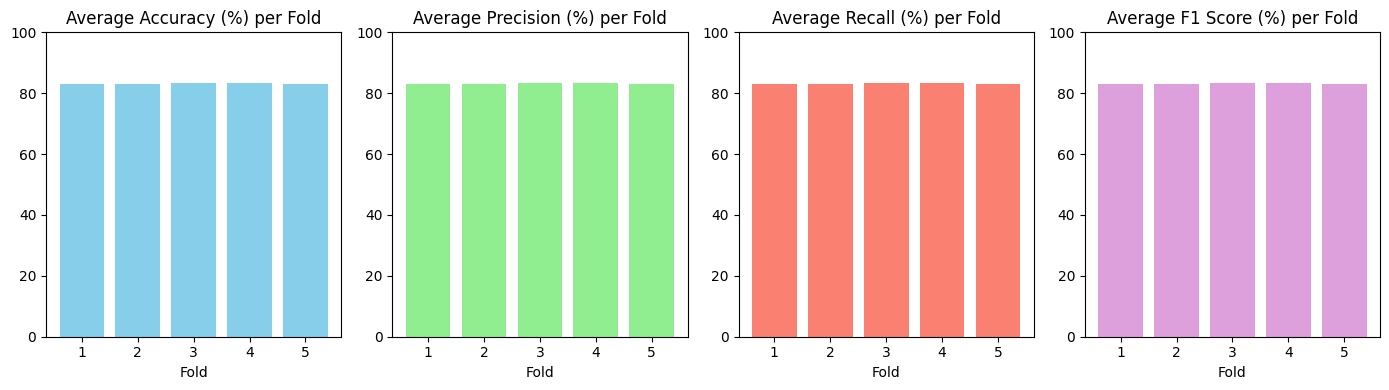


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     82.93       82.94       82.93       82.93       
2     82.96       83.10       82.96       82.94       
3     83.34       83.43       83.34       83.33       
4     83.26       83.34       83.26       83.25       
5     82.97       82.99       82.97       82.97       

Plotting results for experiment: baseline



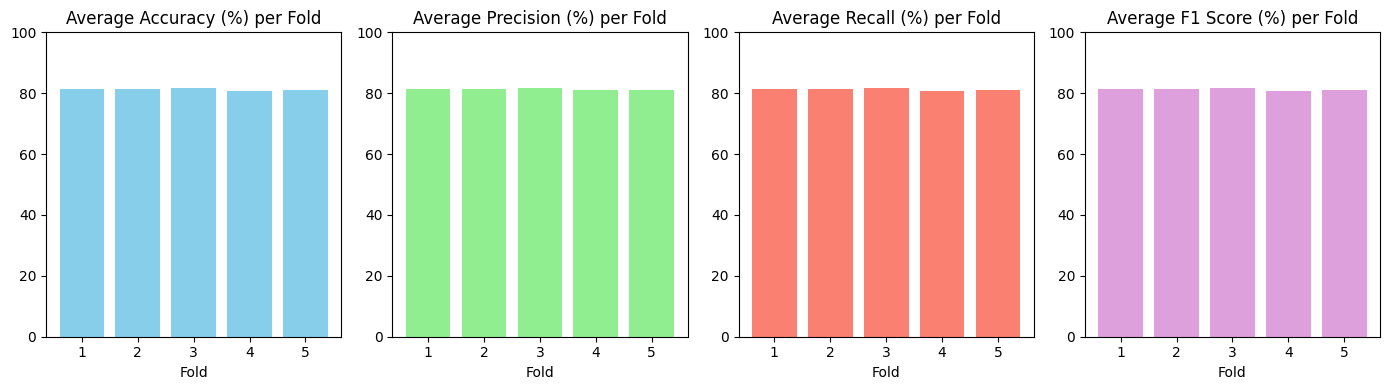


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.48       81.49       81.48       81.48       
2     81.25       81.30       81.25       81.25       
3     81.63       81.66       81.63       81.62       
4     80.81       80.92       80.81       80.79       
5     80.98       81.00       80.98       80.98       

Plotting results for experiment: medium



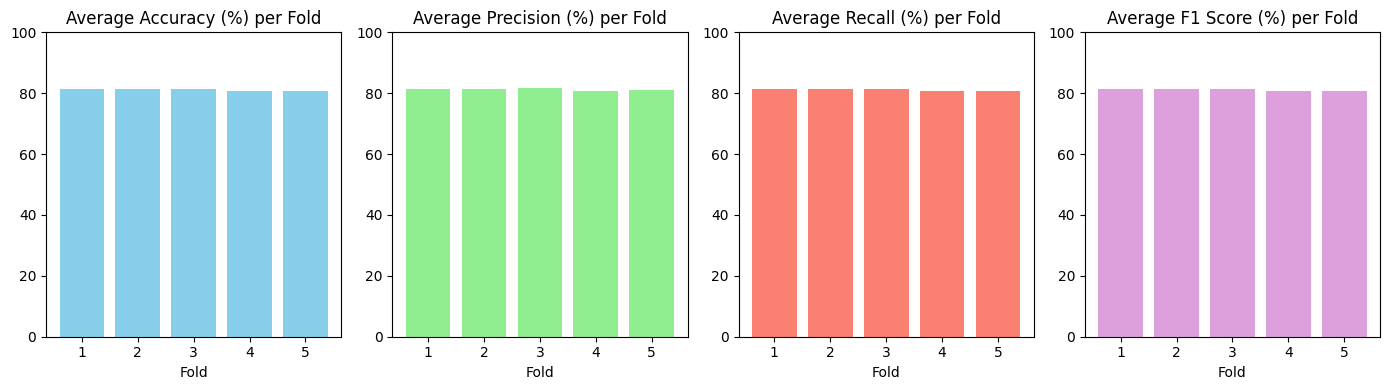


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.32       81.33       81.32       81.32       
2     81.30       81.35       81.30       81.29       
3     81.54       81.57       81.54       81.54       
4     80.74       80.86       80.74       80.72       
5     80.87       80.89       80.87       80.87       

Plotting results for experiment: deep



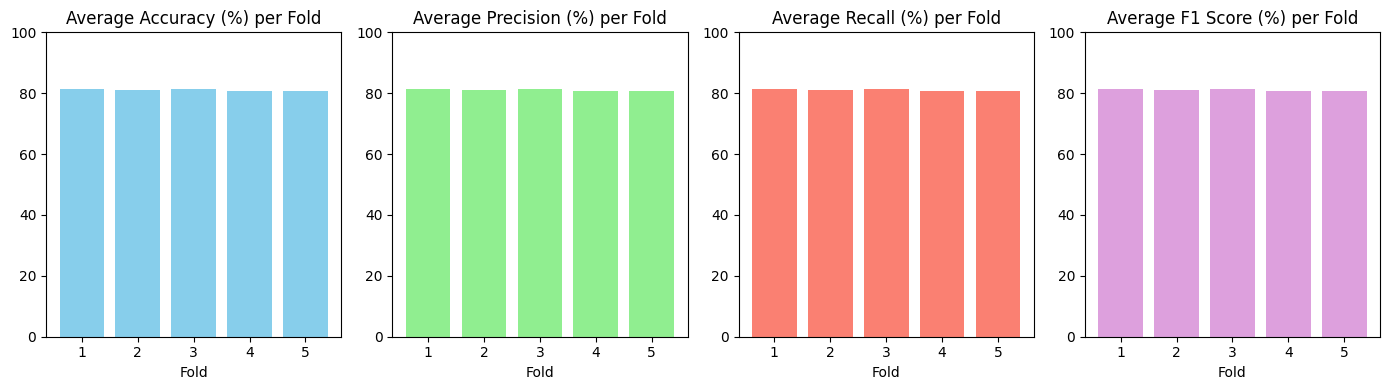


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.47       81.48       81.47       81.47       
2     81.16       81.20       81.16       81.16       
3     81.44       81.45       81.44       81.44       
4     80.70       80.80       80.70       80.68       
5     80.86       80.86       80.86       80.85       

Plotting results for experiment: wide



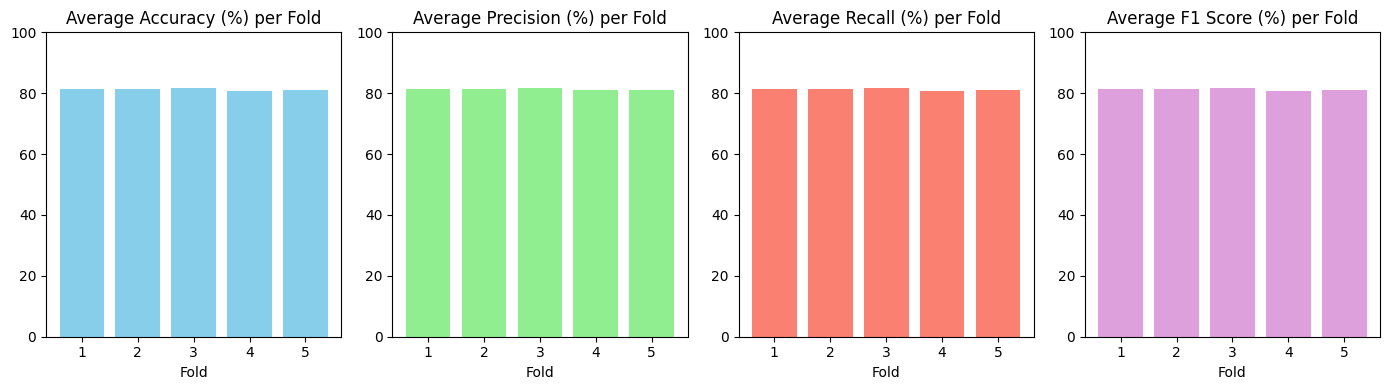


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.46       81.47       81.46       81.46       
2     81.33       81.36       81.33       81.33       
3     81.60       81.65       81.60       81.59       
4     80.88       80.98       80.88       80.87       
5     80.98       81.00       80.98       80.98       

Plotting results for experiment: shallow



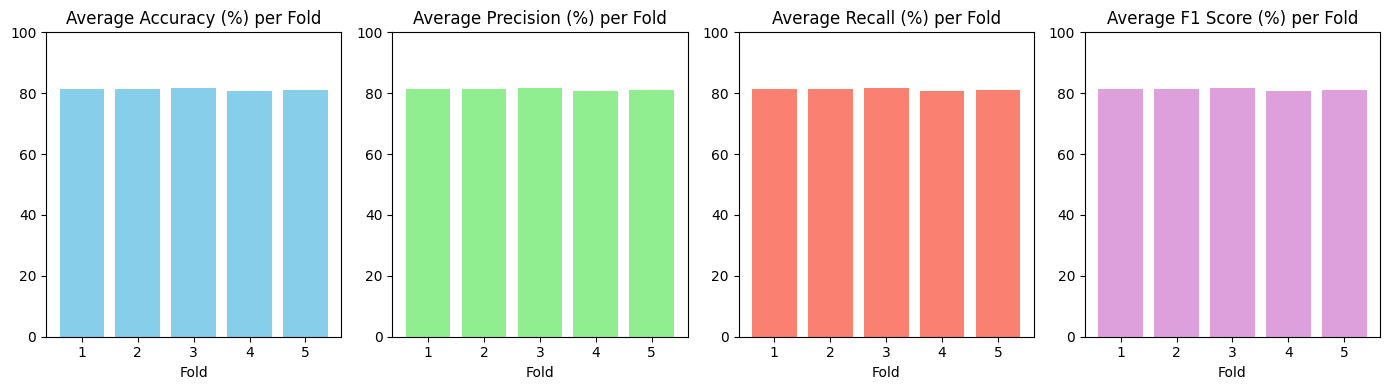


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.39       81.41       81.39       81.38       
2     81.30       81.36       81.30       81.29       
3     81.59       81.64       81.59       81.59       
4     80.72       80.85       80.72       80.69       
5     81.03       81.05       81.03       81.03       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_per_fold(experiment_results)

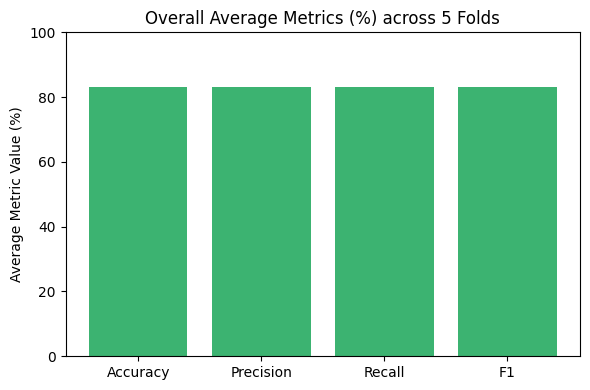


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         83.09
Precision        83.16
Recall           83.09
F1               83.08

Plotting results for experiment: baseline



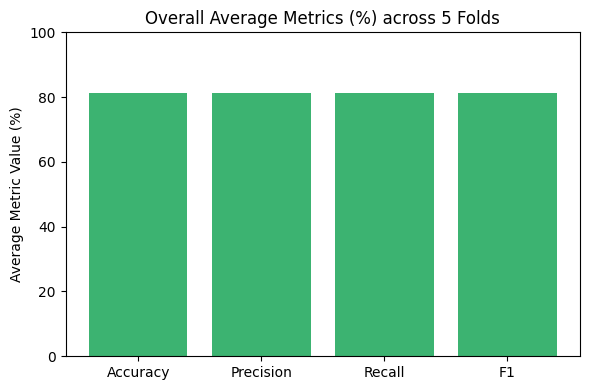


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.23
Precision        81.27
Recall           81.23
F1               81.22

Plotting results for experiment: medium



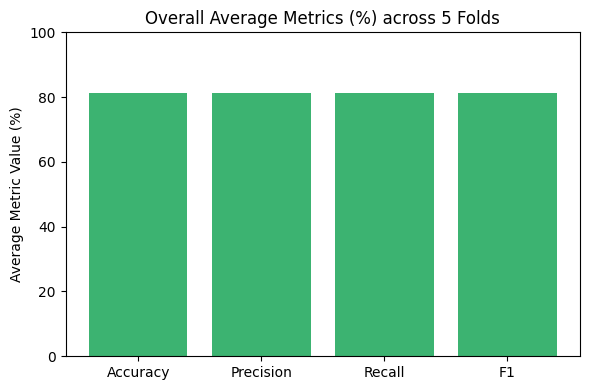


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.15
Precision        81.20
Recall           81.15
F1               81.15

Plotting results for experiment: deep



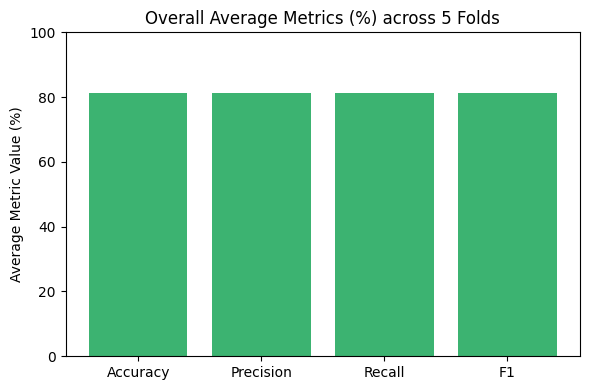


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.12
Precision        81.16
Recall           81.12
F1               81.12

Plotting results for experiment: wide



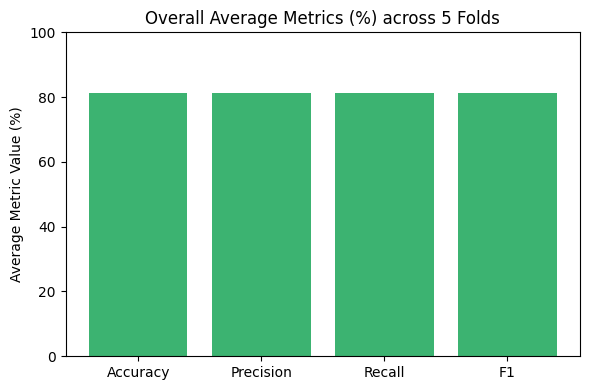


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.25
Precision        81.29
Recall           81.25
F1               81.25

Plotting results for experiment: shallow



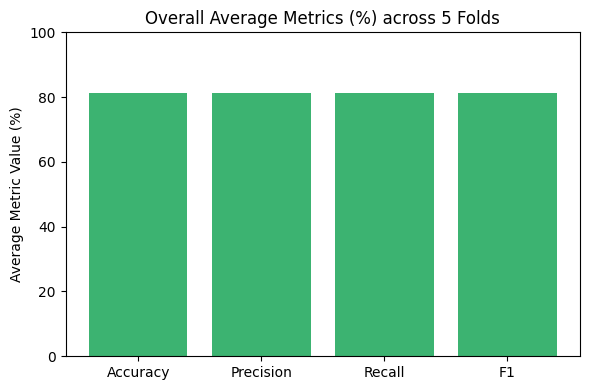


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.21
Precision        81.26
Recall           81.21
F1               81.20


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_across_folds(experiment_results)

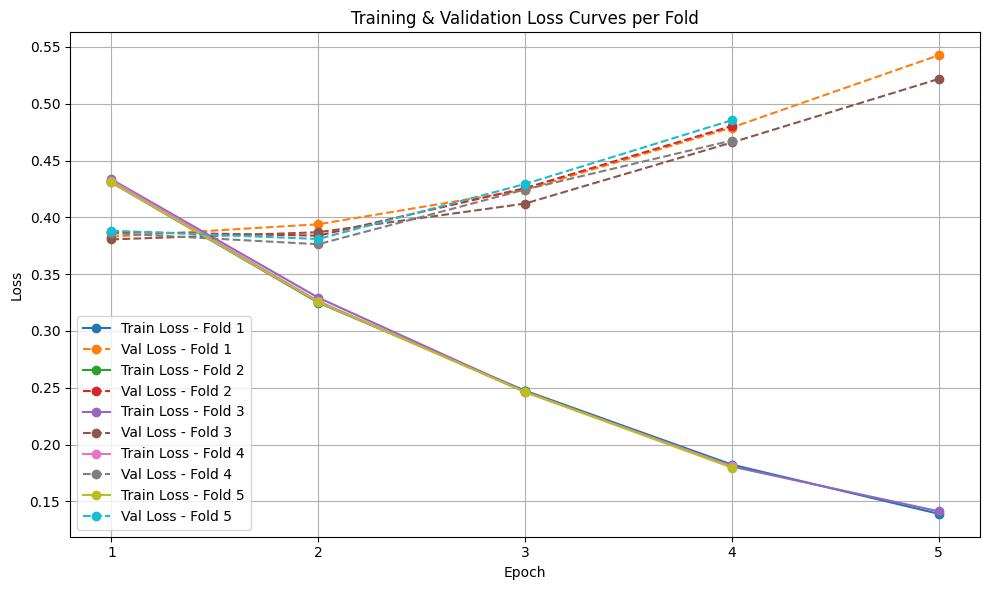


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4307         0.3830         
1     2       0.3249         0.3939         
1     3       0.2474         0.4243         
1     4       0.1823         0.4790         
1     5       0.1390         0.5427         
--------------------------------------------------
2     1       0.4321         0.3872         
2     2       0.3256         0.3839         
2     3       0.2467         0.4257         
2     4       0.1810         0.4804         
--------------------------------------------------
3     1       0.4335         0.3806         
3     2       0.3293         0.3869         
3     3       0.2466         0.4121         
3     4       0.1806         0.4659         
3     5       0.1412         0.5218         
--------------------------------------------------
4     1       0.4324         0.3861  

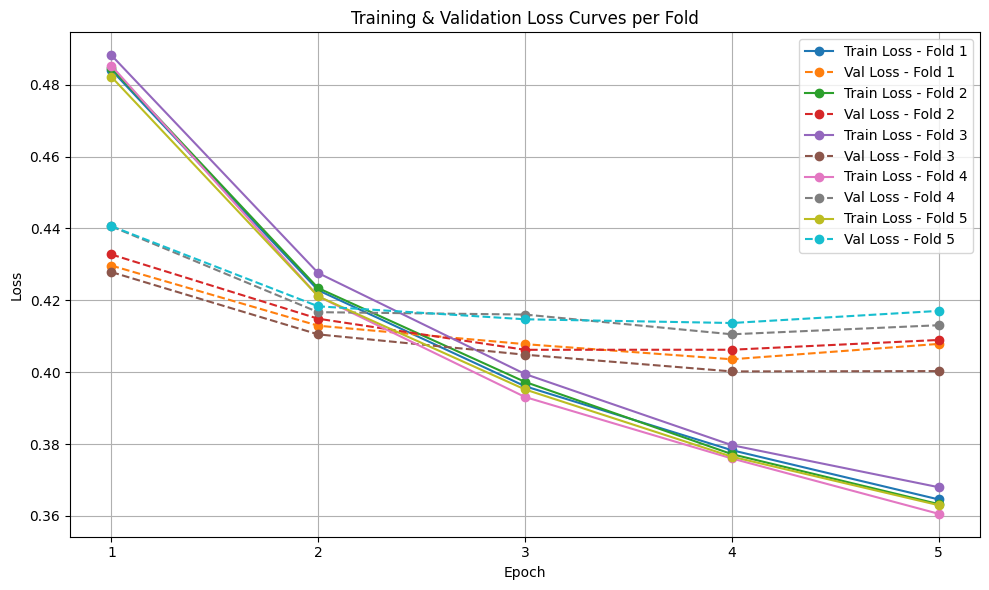


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4841         0.4297         
1     2       0.4228         0.4129         
1     3       0.3961         0.4078         
1     4       0.3783         0.4036         
1     5       0.3646         0.4079         
--------------------------------------------------
2     1       0.4847         0.4328         
2     2       0.4234         0.4149         
2     3       0.3973         0.4062         
2     4       0.3772         0.4063         
2     5       0.3633         0.4090         
--------------------------------------------------
3     1       0.4882         0.4279         
3     2       0.4276         0.4105         
3     3       0.3995         0.4049         
3     4       0.3797         0.4002         
3     5       0.3680         0.4003         
-------------------------------------------

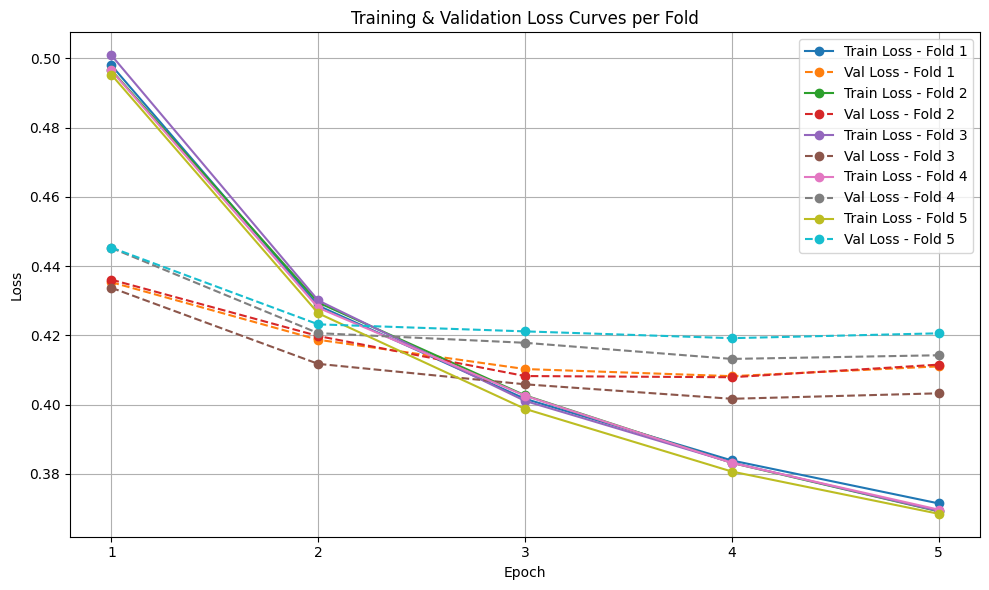


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4980         0.4354         
1     2       0.4286         0.4188         
1     3       0.4017         0.4103         
1     4       0.3839         0.4082         
1     5       0.3715         0.4111         
--------------------------------------------------
2     1       0.4966         0.4361         
2     2       0.4295         0.4198         
2     3       0.4027         0.4083         
2     4       0.3832         0.4079         
2     5       0.3692         0.4116         
--------------------------------------------------
3     1       0.5009         0.4338         
3     2       0.4301         0.4118         
3     3       0.4011         0.4059         
3     4       0.3833         0.4017         
3     5       0.3693         0.4033         
-------------------------------------------

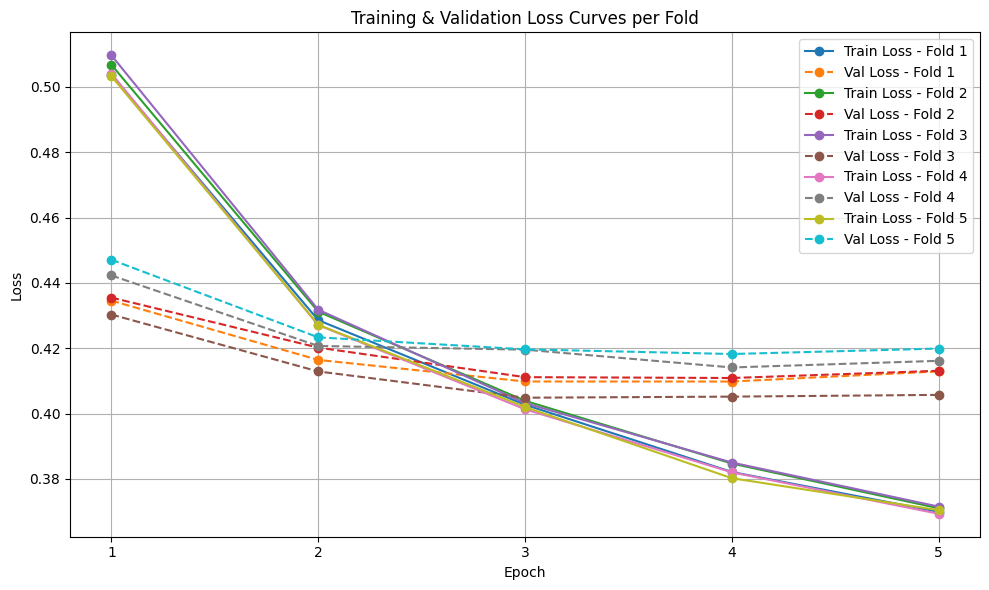


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.5036         0.4346         
1     2       0.4286         0.4164         
1     3       0.4027         0.4098         
1     4       0.3821         0.4098         
1     5       0.3699         0.4129         
--------------------------------------------------
2     1       0.5068         0.4355         
2     2       0.4312         0.4202         
2     3       0.4039         0.4111         
2     4       0.3847         0.4109         
2     5       0.3710         0.4131         
--------------------------------------------------
3     1       0.5097         0.4303         
3     2       0.4318         0.4129         
3     3       0.4032         0.4048         
3     4       0.3850         0.4052         
3     5       0.3715         0.4057         
-------------------------------------------

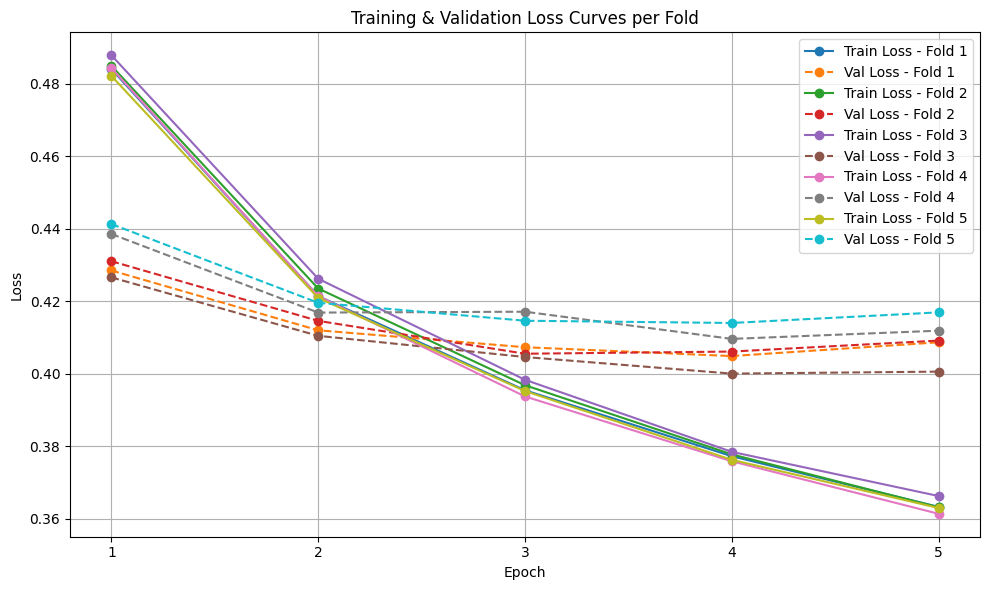


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4841         0.4285         
1     2       0.4214         0.4120         
1     3       0.3954         0.4073         
1     4       0.3772         0.4049         
1     5       0.3632         0.4086         
--------------------------------------------------
2     1       0.4850         0.4310         
2     2       0.4235         0.4146         
2     3       0.3968         0.4055         
2     4       0.3777         0.4061         
2     5       0.3631         0.4091         
--------------------------------------------------
3     1       0.4879         0.4266         
3     2       0.4262         0.4104         
3     3       0.3983         0.4046         
3     4       0.3784         0.4000         
3     5       0.3662         0.4006         
-------------------------------------------

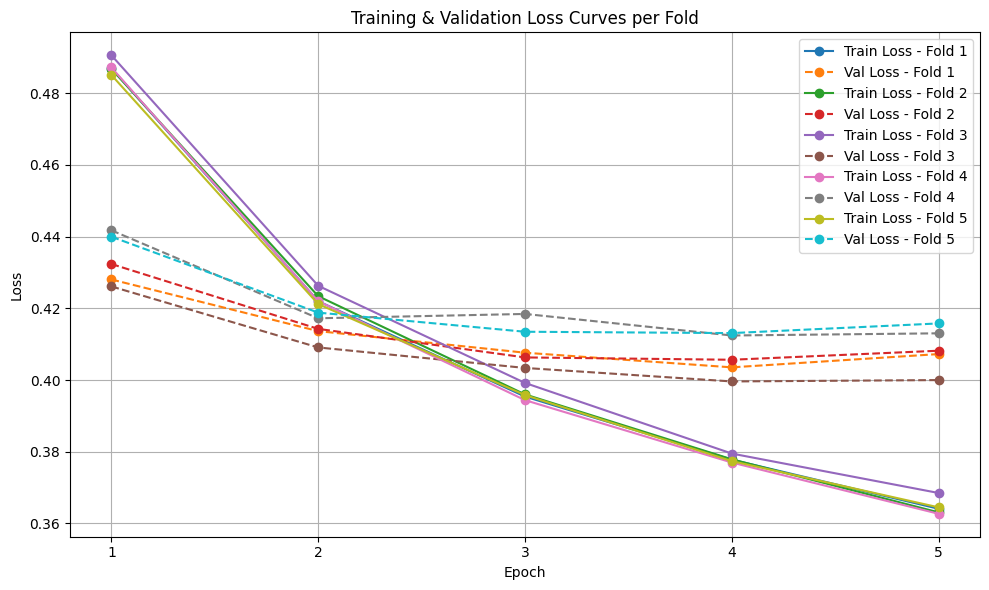


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4870         0.4281         
1     2       0.4220         0.4137         
1     3       0.3954         0.4076         
1     4       0.3778         0.4035         
1     5       0.3641         0.4073         
--------------------------------------------------
2     1       0.4868         0.4324         
2     2       0.4234         0.4143         
2     3       0.3960         0.4063         
2     4       0.3779         0.4057         
2     5       0.3631         0.4082         
--------------------------------------------------
3     1       0.4906         0.4261         
3     2       0.4263         0.4091         
3     3       0.3992         0.4034         
3     4       0.3795         0.3996         
3     5       0.3685         0.4000         
-------------------------------------------

In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_loss_per_fold(experiment_results)

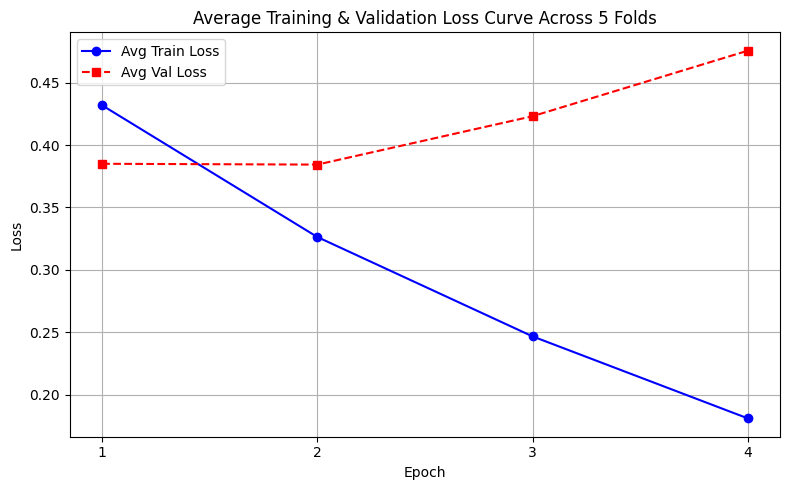


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4319          0.3850          
2       0.3263          0.3844          
3       0.2466          0.4232          
4       0.1809          0.4757          

Plotting results for experiment: baseline



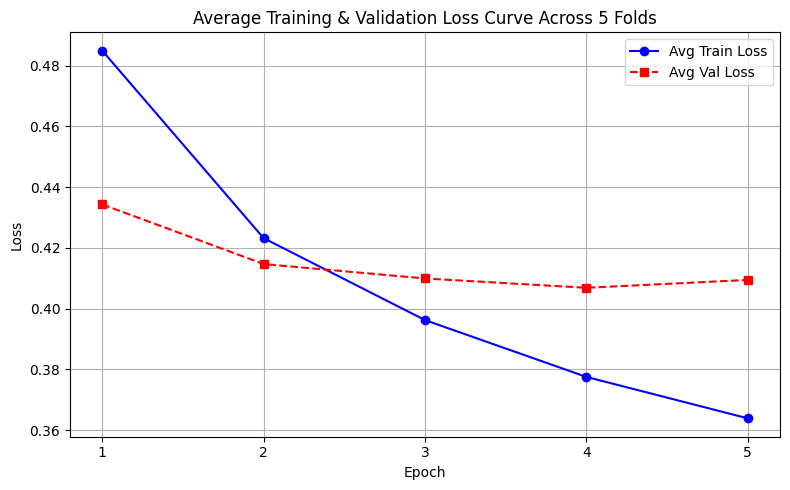


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4849          0.4343          
2       0.4232          0.4147          
3       0.3962          0.4099          
4       0.3775          0.4069          
5       0.3639          0.4095          

Plotting results for experiment: medium



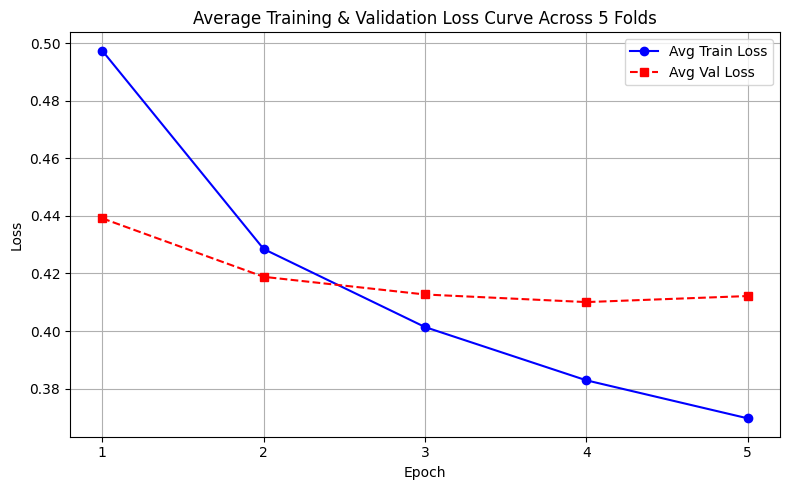


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4975          0.4392          
2       0.4285          0.4188          
3       0.4014          0.4127          
4       0.3829          0.4101          
5       0.3696          0.4122          

Plotting results for experiment: deep



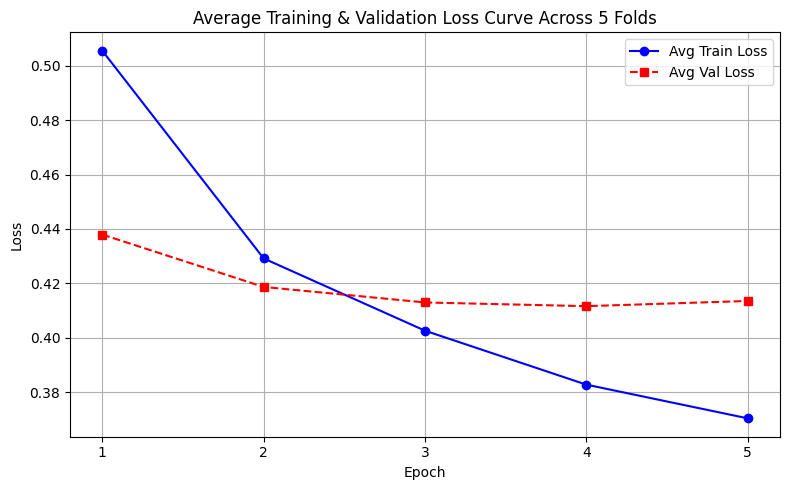


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.5055          0.4380          
2       0.4292          0.4187          
3       0.4026          0.4130          
4       0.3828          0.4116          
5       0.3704          0.4135          

Plotting results for experiment: wide



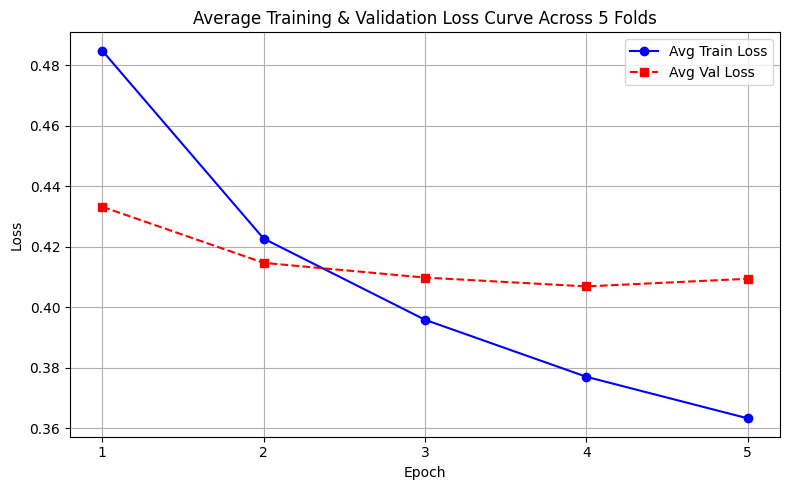


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4847          0.4332          
2       0.4227          0.4147          
3       0.3959          0.4098          
4       0.3771          0.4069          
5       0.3633          0.4094          

Plotting results for experiment: shallow



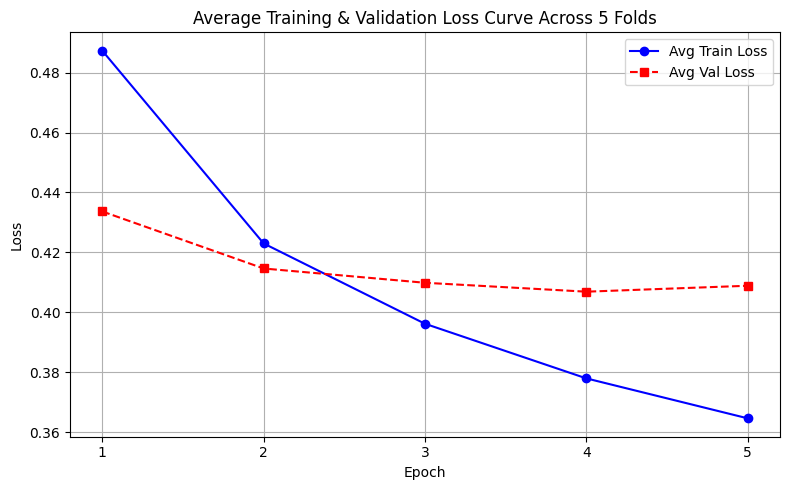


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4873          0.4337          
2       0.4230          0.4146          
3       0.3962          0.4099          
4       0.3779          0.4069          
5       0.3646          0.4089          


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_loss_across_folds(experiment_results)

---
# **3.3 Final Model Training**

## Define Final Training Arguments

In [ ]:
def create_final_training_args(model_loader):
    training_args = TrainingArguments(
        output_dir=f"./final_results_{model_loader.__name__}",   # Directory to store checkpoints
        do_train=True,
        report_to="none",                                        # Disable external logging (e.g., WandB)
        eval_strategy="no",                                      # No evaluation during training
        save_strategy="no",                                      # Do not save at each epoch
        per_device_train_batch_size=8,
        num_train_epochs=5,
        learning_rate=3e-5,
        weight_decay=0.01,
        fp16=True,                                               # Enable mixed precision
        gradient_accumulation_steps=16,                          # Accumulate gradients
        logging_dir=f"./final_logs_{model_loader.__name__}",     # Directory for training logs
        logging_strategy="epoch",                                # Log training loss once per epoch
        seed=42                                                  # For reproducibility
    )
    return training_args

## Model Training

In [ ]:
def train_final_model(train_dataset, training_args, model_loader):

    # Train the final model on the full training dataset

    # Load the model using the helper function
    model = model_loader()
    model.to(device)

    # Initialize the Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics  # Metrics won't be computed during training since evaluation is disabled
    )

    # Start training the final model
    trainer.train()

    return trainer, model

In [ ]:
# Prepare the full training dataset
full_train_dataset = prepare_dataset(x_train, y_train)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_final_training_args(model_loader)
final_pretrained_trainer, final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
625,0.422200
1250,0.321200
1875,0.245900
2500,0.180000
3125,0.139200


In [ ]:
best_exp_name = None
best_f1 = -np.inf

print("Average Metrics for Each Experiment:")
for name, results in fold_results_custom_model.items():
    # Extract F1 scores from each fold's average metrics
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]
    avg_f1 = np.nanmean(f1s)
    print(f"{name:<10} | Avg F1: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_exp_name = name

# Retrieve the best hidden_units configuration from experiments list
best_hidden_units = None
for exp in experiments:
    if exp["name"] == best_exp_name:
        best_hidden_units = exp["hidden_units"]
        break

print(f"\nBest configuration: {best_exp_name} with hidden_units: {best_hidden_units} and avg F1: {best_f1:.4f}")

# Train the final model using custom DistilBert
model_loader = lambda: load_custom_model(hidden_units=best_hidden_units, dropout_rate=0.3, activation=nn.ReLU)
training_args = create_final_training_args(model_loader)
final_custom_trainer, final_custom_model = train_final_model(full_train_dataset, training_args, model_loader)

Average Metrics for Each Experiment:
baseline   | Avg F1: 0.8122
medium     | Avg F1: 0.8115
deep       | Avg F1: 0.8112
wide       | Avg F1: 0.8125
shallow    | Avg F1: 0.8120

Best configuration: wide with hidden_units: [512] and avg F1: 0.8125


<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
625,0.474700
1250,0.414700
1875,0.388500
2500,0.369200
3125,0.355400


---
# **3.4 Final Model Evaluation**

In [ ]:
def evaluate_final_model(trainer, eval_dataset):
    final_test_results = trainer.evaluate(eval_dataset)

    # Extract key metrics
    eval_loss = final_test_results.get("eval_loss", "N/A")
    eval_accuracy = final_test_results.get("eval_accuracy", "N/A")
    eval_precision = final_test_results.get("eval_precision", "N/A")
    eval_recall = final_test_results.get("eval_recall", "N/A")
    eval_f1 = final_test_results.get("eval_f1", "N/A")

    print("\nFinal Model Evaluation on the Test Set:")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{eval_accuracy:.4f} ({eval_accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{eval_precision:.4f} ({eval_precision * 100:.2f}%)")
    print(f"{'Recall':<15}{eval_recall:.4f} ({eval_recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{eval_f1:.4f} ({eval_f1 * 100:.2f}%)")
    print(f"{'Loss':<15}{eval_loss:.4f}")
    print("-" * 50)

    return final_test_results

In [ ]:
# Prepare the test set
test_dataset = prepare_dataset(x_test, y_test)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8294 (82.94%)
Precision      0.8294 (82.94%)
Recall         0.8294 (82.94%)
F1 Score       0.8293 (82.93%)
Loss           0.5347
--------------------------------------------------


{'eval_loss': 0.5347115993499756,
 'eval_accuracy': 0.82935,
 'eval_precision': 0.8293639156254352,
 'eval_recall': 0.82935,
 'eval_f1': 0.829348197490336,
 'eval_runtime': 22.494,
 'eval_samples_per_second': 889.128,
 'eval_steps_per_second': 111.141,
 'epoch': 5.0}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8207 (82.07%)
Precision      0.8208 (82.08%)
Recall         0.8207 (82.07%)
F1 Score       0.8207 (82.07%)
Loss           0.4035
--------------------------------------------------


{'eval_loss': 0.40347886085510254,
 'eval_accuracy': 0.8207,
 'eval_precision': 0.8207993708131031,
 'eval_recall': 0.8207,
 'eval_f1': 0.8206861139326629,
 'eval_runtime': 21.7914,
 'eval_samples_per_second': 917.795,
 'eval_steps_per_second': 114.724,
 'epoch': 5.0}

---
# **3.5 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics

In [ ]:
def predict_final_model_with_metrics(trainer, eval_dataset, output_dir=None, class_labels=None):
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Compute metrics
    accuracy = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(true_labels, preds)

    # Classification report (per class)
    if class_labels:
        report = classification_report(true_labels, preds, target_names=class_labels, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, target_names=class_labels, digits=4)
    else:
        report = classification_report(true_labels, preds, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, digits=4)

    # Print summary of metrics
    print("\nFinal Model Predictions Summary")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{accuracy:.4f} ({accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{precision:.4f} ({precision * 100:.2f}%)")
    print(f"{'Recall':<15}{recall:.4f} ({recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{f1:.4f} ({f1 * 100:.2f}%)")
    print("-" * 50)

    print("\nClassification Report (Per Class):")
    print(report_text)

    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f"{output_dir}/confusion_matrix.png")
        print(f"\nConfusion matrix saved to {output_dir}/confusion_matrix.png\n")
    plt.show()

    metrics = {
        "eval_accuracy": accuracy,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1
    }

    return metrics, cm, preds, true_labels


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8294 (82.94%)
Precision      0.8294 (82.94%)
Recall         0.8294 (82.94%)
F1 Score       0.8293 (82.93%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8272    0.8326    0.8299     10000
    Positive     0.8315    0.8261    0.8288     10000

    accuracy                         0.8294     20000
   macro avg     0.8294    0.8294    0.8293     20000
weighted avg     0.8294    0.8294    0.8293     20000


Confusion Matrix:
[[8326 1674]
 [1739 8261]]

Confusion matrix saved to ./1_Initial_Pretrained_Model_Raw_Tweets/confusion_matrix.png



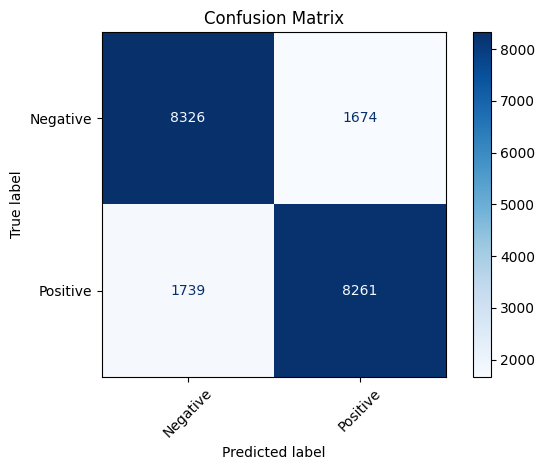

In [ ]:
model_name = "1_Initial_Pretrained_Model_Raw_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8207 (82.07%)
Precision      0.8208 (82.08%)
Recall         0.8207 (82.07%)
F1 Score       0.8207 (82.07%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8152    0.8295    0.8223     10000
    Positive     0.8264    0.8119    0.8191     10000

    accuracy                         0.8207     20000
   macro avg     0.8208    0.8207    0.8207     20000
weighted avg     0.8208    0.8207    0.8207     20000


Confusion Matrix:
[[8295 1705]
 [1881 8119]]

Confusion matrix saved to ./1_Initial_Custom_Model_Raw_Tweets/confusion_matrix.png



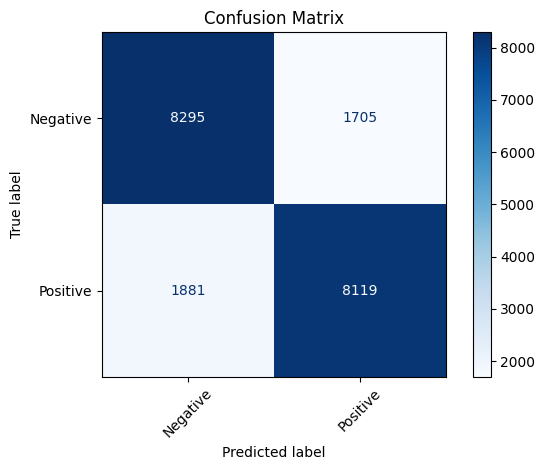

In [ ]:
model_name = "1_Initial_Custom_Model_Raw_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **3.6 Save Final Model**

**Note**: If you are running this code chunk, please change the `drive_base_path` to `"/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"`. If not, you may access the saved model in the `Trained Model Links` file.

In [ ]:
def save_model_to_drive(model, tokenizer, model_name, metrics=None):

    # Mount Google Drive
    drive.mount("/content/drive", force_remount=True)

    # Paths
    local_path = f"./{model_name}"
    drive_base_path = "/content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model" # or change to "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"
    drive_path = os.path.join(drive_base_path, model_name)

    # Create local directory if it doesn't exist
    if not os.path.exists(local_path):
        os.makedirs(local_path)

    # Save the model and tokenizer locally
    # Check if the model is an instance of a Hugging Face PreTrainedModel
    if isinstance(model, torch.nn.Module):
        # Save the model's state_dict instead of using save_pretrained
        torch.save(model.state_dict(), os.path.join(local_path, "model_state_dict.pth"))
    else:
        model.save_pretrained(local_path)

    tokenizer.save_pretrained(local_path)

    # Save metrics to local folder
    if metrics:
        with open(os.path.join(local_path, "metrics.json"), "w") as f:
            json.dump(metrics, f, indent=4)

    # Remove old copy in Google Drive (if exists)
    if os.path.exists(drive_path):
        try:
            shutil.rmtree(drive_path)
        except Exception as e:
            print(f"Error removing existing folder {drive_path}: {e}")

    # Copy local folder to Google Drive
    try:
        shutil.copytree(local_path, drive_path)
        print(f"Model and metrics saved to Google Drive at: {drive_path}")
    except Exception as e:
        print(f"Error copying model to Google Drive: {e}")

In [ ]:
model_name = "1_Initial_Pretrained_Model_Raw_Tweets"
final_model_eval_metrics = evaluate_final_model(final_pretrained_trainer, test_dataset)
metrics1 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_pretrained_model, tokenizer, model_name, metrics=metrics1)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8294 (82.94%)
Precision      0.8294 (82.94%)
Recall         0.8294 (82.94%)
F1 Score       0.8293 (82.93%)
Loss           0.5347
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Pretrained_Model_Raw_Tweets


In [ ]:
model_name = "1_Initial_Custom_Model_Raw_Tweets"
final_model_eval_metrics = evaluate_final_model(final_custom_trainer, test_dataset)
metrics2 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_custom_model, tokenizer, model_name, metrics=metrics2)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8207 (82.07%)
Precision      0.8208 (82.08%)
Recall         0.8207 (82.07%)
F1 Score       0.8207 (82.07%)
Loss           0.4035
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Custom_Model_Raw_Tweets


---
# **4. Hyperparameter Fine-Tuning Using Optuna**

---
# **4.1 Fine-Tuned Model Training & Evaluation**

## Helper Function: Run just the first fold

In [ ]:
def run_first_fold(x_train, y_train, training_args, model_loader):
    # Create a StratifiedKFold object with 5 splits
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the folds, but break after the first one
    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/1 (only the first fold will be used)")

        # Split data for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate on this fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)

        # Return the result of the first fold and exit
        return result

## Define Base Training Arguments for Hyperparameter Search

In [ ]:
def create_base_training_args(
    model_loader,
    learning_rate,
    batch_size,
    grad_acc,
    weight_decay,
    warmup_steps,
    max_grad_norm,
    adam_epsilon,
    scheduler_choice
):
    return TrainingArguments(
        output_dir=f"./base_results_{model_loader.__name__}",
        report_to="none",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        fp16=True,
        gradient_accumulation_steps=grad_acc,
        logging_dir=f"./base_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        seed=42,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        lr_scheduler_type=scheduler_choice
    )

## Objective for Optuna

In [ ]:
def optuna_objective_distilbert(trial):
    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    model_loader = load_pretrained_model

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

In [ ]:
def optuna_objective_custom_model(trial):
    # Architecture parameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_units = [trial.suggest_categorical(f"hidden_size_{i}", [64, 128, 256, 512])
                    for i in range(n_layers)]

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation_choice = trial.suggest_categorical("activation", ["relu", "gelu", "tanh"])

    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    # Map activation function string to torch.nn module
    activation_map = {
        "relu": nn.ReLU,
        "gelu": nn.GELU,
        "tanh": nn.Tanh
    }

    # Model loader using the current trial's architecture parameters
    model_loader = lambda: load_custom_model(
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation_map[activation_choice]
    )

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Pretrained DistilBert
study1 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study1.optimize(optuna_objective_distilbert, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study1.best_value:.4f}")
for key, value in study1.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-29 09:41:40,497] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.428400,0.378675,0.832187,0.832227,0.832187,0.832183
2,0.311900,0.399878,0.831375,0.831378,0.831375,0.831375
3,0.210100,0.466257,0.829375,0.829394,0.829375,0.829373


[I 2025-03-29 09:51:52,698] Trial 0 finished with value: 0.8309765864619472 and parameters: {'learning_rate': 4.166117390263535e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.15668424111983706, 'warmup_steps': 297, 'max_grad_norm': 1.9191104791683427, 'adam_epsilon': 4.7290734095686607e-07, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8309765864619472.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4149
eval_accuracy            : 0.8310
eval_precision           : 0.8310
eval_recall              : 0.8310
eval_f1                  : 0.8310
eval_runtime             : 17.8284
eval_samples_per_second  : 897.4447
eval_steps_per_second    : 112.1807

Loss History:
- Training Loss per Epoch   : ['0.4284', '0.3119', '0.2101']
- Validation Loss per Epoch : ['0.3787', '0.3999', '0.4663']
- Average Training Loss     : 0.3168
- Average Validation Loss   : 0.4149

Trial Summary:
eval_loss      : 0.4149
eval_accuracy  : 0.8310
eval_precision : 0.8310
eval_recall    : 0.8310
eval_f1        : 0.8310
eval_runtime   : 17.8284
eval_samples_per_second: 897.4447
eval_steps_per_second: 112.1807

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.510100,0.415762,0.811250,0.811499,0.811250,0.811212
2,0.400800,0.398596,0.820125,0.821253,0.820125,0.819967
3,0.364500,0.393815,0.828313,0.829900,0.828313,0.828106
4,0.333900,0.388786,0.828125,0.829242,0.828125,0.827979
5,0.303400,0.400164,0.829937,0.830880,0.829937,0.829816


[I 2025-03-29 09:57:12,106] Trial 1 finished with value: 0.823416074871543 and parameters: {'learning_rate': 1.2231337021441538e-05, 'batch_size': 32, 'grad_acc': 16, 'weight_decay': 0.1730009435522883, 'warmup_steps': 434, 'max_grad_norm': 1.0860400987453578, 'adam_epsilon': 1.1623932327190742e-07, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8309765864619472.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.3994
eval_accuracy            : 0.8236
eval_precision           : 0.8246
eval_recall              : 0.8236
eval_f1                  : 0.8234
eval_runtime             : 6.4971
eval_samples_per_second  : 2462.7196
eval_steps_per_second    : 76.9600

Loss History:
- Training Loss per Epoch   : ['0.5101', '0.4008', '0.3645', '0.3339', '0.3034']
- Validation Loss per Epoch : ['0.4158', '0.3986', '0.3938', '0.3888', '0.4002']
- Average Training Loss     : 0.3825
- Average Validation Loss   : 0.3994

Trial Summary:
eval_loss      : 0.3994
eval_accuracy  : 0.8236
eval_precision : 0.8246
eval_recall    : 0.8236
eval_f1        : 0.8234
eval_runtime   : 6.4971
eval_samples_per_second: 2462.7196
eval_steps_per_second: 76.9600

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.429400,0.377740,0.833313,0.833313,0.833313,0.833312
2,0.304700,0.394818,0.835938,0.836600,0.835938,0.835857
3,0.194300,0.469119,0.831125,0.831145,0.831125,0.831122
4,0.115000,0.598839,0.827313,0.827554,0.827313,0.827281


[I 2025-03-29 10:05:04,645] Trial 2 finished with value: 0.8318930970022433 and parameters: {'learning_rate': 3.186722872449945e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.06253142746427279, 'warmup_steps': 49, 'max_grad_norm': 1.3680168326877964, 'adam_epsilon': 7.382949556424273e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4601
eval_accuracy            : 0.8319
eval_precision           : 0.8322
eval_recall              : 0.8319
eval_f1                  : 0.8319
eval_runtime             : 10.3013
eval_samples_per_second  : 1553.2315
eval_steps_per_second    : 97.0770

Loss History:
- Training Loss per Epoch   : ['0.4294', '0.3047', '0.1943', '0.1150']
- Validation Loss per Epoch : ['0.3777', '0.3948', '0.4691', '0.5988']
- Average Training Loss     : 0.2609
- Average Validation Loss   : 0.4601

Trial Summary:
eval_loss      : 0.4601
eval_accuracy  : 0.8319
eval_precision : 0.8322
eval_recall    : 0.8319
eval_f1        : 0.8319
eval_runtime   : 10.3013
eval_samples_per_second: 1553.2315
eval_steps_per_second: 97.0770

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.526200,0.407191,0.816375,0.816528,0.816375,0.816353
2,0.387600,0.384392,0.828063,0.828428,0.828063,0.828015
3,0.315000,0.391411,0.834125,0.834158,0.834125,0.834121
4,0.222800,0.441833,0.831562,0.831570,0.831562,0.831562
5,0.160100,0.499578,0.829313,0.829334,0.829313,0.829310


[I 2025-03-29 10:14:33,167] Trial 3 finished with value: 0.8278719041341202 and parameters: {'learning_rate': 3.6570283156458896e-05, 'batch_size': 16, 'grad_acc': 16, 'weight_decay': 0.1401157217916639, 'warmup_steps': 450, 'max_grad_norm': 0.7672881076100984, 'adam_epsilon': 1.811329907410552e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4249
eval_accuracy            : 0.8279
eval_precision           : 0.8280
eval_recall              : 0.8279
eval_f1                  : 0.8279
eval_runtime             : 10.4083
eval_samples_per_second  : 1537.3948
eval_steps_per_second    : 96.0872

Loss History:
- Training Loss per Epoch   : ['0.5262', '0.3876', '0.3150', '0.2228', '0.1601']
- Validation Loss per Epoch : ['0.4072', '0.3844', '0.3914', '0.4418', '0.4996']
- Average Training Loss     : 0.3223
- Average Validation Loss   : 0.4249

Trial Summary:
eval_loss      : 0.4249
eval_accuracy  : 0.8279
eval_precision : 0.8280
eval_recall    : 0.8279
eval_f1        : 0.8279
eval_runtime   : 10.4083
eval_samples_per_second: 1537.3948
eval_steps_per_second: 96.0872

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.491400,0.396718,0.823000,0.823078,0.823000,0.822989
2,0.367200,0.386733,0.828688,0.828841,0.828688,0.828667
3,0.312000,0.393131,0.833250,0.833251,0.833250,0.833250
4,0.269500,0.408956,0.831812,0.831901,0.831812,0.831801
5,0.245900,0.424128,0.831250,0.831256,0.831250,0.831249


[I 2025-03-29 10:31:41,445] Trial 4 finished with value: 0.8295914345743232 and parameters: {'learning_rate': 1.4668021861903627e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.175974114878947, 'warmup_steps': 225, 'max_grad_norm': 0.6161516956024876, 'adam_epsilon': 1.1849160130781541e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4019
eval_accuracy            : 0.8296
eval_precision           : 0.8297
eval_recall              : 0.8296
eval_f1                  : 0.8296
eval_runtime             : 17.9191
eval_samples_per_second  : 892.9108
eval_steps_per_second    : 111.6138

Loss History:
- Training Loss per Epoch   : ['0.4914', '0.3672', '0.3120', '0.2695', '0.2459']
- Validation Loss per Epoch : ['0.3967', '0.3867', '0.3931', '0.4090', '0.4241']
- Average Training Loss     : 0.3372
- Average Validation Loss   : 0.4019

Trial Summary:
eval_loss      : 0.4019
eval_accuracy  : 0.8296
eval_precision : 0.8297
eval_recall    : 0.8296
eval_f1        : 0.8296
eval_runtime   : 17.9191
eval_samples_per_second: 892.9108
eval_steps_per_second: 111.6138

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.429800,0.386531,0.829187,0.830323,0.829187,0.829041
2,0.311300,0.404369,0.833625,0.834272,0.833625,0.833544
3,0.220600,0.524819,0.831375,0.831479,0.831375,0.831362
4,0.160000,0.734900,0.826812,0.826917,0.826812,0.826799


[I 2025-03-29 10:40:51,208] Trial 5 finished with value: 0.8301863563226899 and parameters: {'learning_rate': 1.8483246448960864e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.24764873632224185, 'warmup_steps': 187, 'max_grad_norm': 0.7433644774378245, 'adam_epsilon': 7.034652833101583e-08, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.5127
eval_accuracy            : 0.8302
eval_precision           : 0.8307
eval_recall              : 0.8302
eval_f1                  : 0.8302
eval_runtime             : 10.3186
eval_samples_per_second  : 1550.6098
eval_steps_per_second    : 96.9130

Loss History:
- Training Loss per Epoch   : ['0.4298', '0.3113', '0.2206', '0.1600']
- Validation Loss per Epoch : ['0.3865', '0.4044', '0.5248', '0.7349']
- Average Training Loss     : 0.2804
- Average Validation Loss   : 0.5127

Trial Summary:
eval_loss      : 0.5127
eval_accuracy  : 0.8302
eval_precision : 0.8307
eval_recall    : 0.8302
eval_f1        : 0.8302
eval_runtime   : 10.3186
eval_samples_per_second: 1550.6098
eval_steps_per_second: 96.9130

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.439300,0.380655,0.829937,0.829968,0.829937,0.829934
2,0.304100,0.394778,0.831875,0.831907,0.831875,0.831871
3,0.187400,0.482839,0.827313,0.827549,0.827313,0.827281
4,0.104300,0.624122,0.826812,0.826880,0.826812,0.826804


[I 2025-03-29 10:54:50,189] Trial 6 finished with value: 0.8289723577489678 and parameters: {'learning_rate': 4.2614619071944385e-05, 'batch_size': 8, 'grad_acc': 8, 'weight_decay': 0.16409471388271188, 'warmup_steps': 185, 'max_grad_norm': 0.9100732495052232, 'adam_epsilon': 6.018378521698195e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4706
eval_accuracy            : 0.8290
eval_precision           : 0.8291
eval_recall              : 0.8290
eval_f1                  : 0.8290
eval_runtime             : 18.0032
eval_samples_per_second  : 888.7853
eval_steps_per_second    : 111.0982

Loss History:
- Training Loss per Epoch   : ['0.4393', '0.3041', '0.1874', '0.1043']
- Validation Loss per Epoch : ['0.3807', '0.3948', '0.4828', '0.6241']
- Average Training Loss     : 0.2588
- Average Validation Loss   : 0.4706

Trial Summary:
eval_loss      : 0.4706
eval_accuracy  : 0.8290
eval_precision : 0.8291
eval_recall    : 0.8290
eval_f1        : 0.8290
eval_runtime   : 18.0032
eval_samples_per_second: 888.7853
eval_steps_per_second: 111.0982

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457500,0.384044,0.826750,0.826891,0.826750,0.826731
2,0.330600,0.392444,0.832000,0.832242,0.832000,0.831969
3,0.237200,0.436665,0.831375,0.831408,0.831375,0.831371
4,0.159100,0.531033,0.828500,0.828678,0.828500,0.828477


[I 2025-03-29 11:08:53,926] Trial 7 finished with value: 0.8296370825482217 and parameters: {'learning_rate': 2.6183876138288035e-05, 'batch_size': 8, 'grad_acc': 8, 'weight_decay': 0.029123710159892666, 'warmup_steps': 452, 'max_grad_norm': 1.3074920876096503, 'adam_epsilon': 1.2584352842584193e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4360
eval_accuracy            : 0.8297
eval_precision           : 0.8298
eval_recall              : 0.8297
eval_f1                  : 0.8296
eval_runtime             : 18.0241
eval_samples_per_second  : 887.7045
eval_steps_per_second    : 110.9627

Loss History:
- Training Loss per Epoch   : ['0.4575', '0.3306', '0.2372', '0.1591']
- Validation Loss per Epoch : ['0.3840', '0.3924', '0.4367', '0.5310']
- Average Training Loss     : 0.2961
- Average Validation Loss   : 0.4360

Trial Summary:
eval_loss      : 0.4360
eval_accuracy  : 0.8297
eval_precision : 0.8298
eval_recall    : 0.8297
eval_f1        : 0.8296
eval_runtime   : 18.0241
eval_samples_per_second: 887.7045
eval_steps_per_second: 110.9627

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.455100,0.396488,0.820438,0.820438,0.820438,0.820437
2,0.370000,0.388493,0.829187,0.829391,0.829187,0.829161
3,0.324900,0.394340,0.830250,0.830253,0.830250,0.830250
4,0.281400,0.418343,0.832438,0.832696,0.832438,0.832405
5,0.237800,0.455707,0.826500,0.826624,0.826500,0.826484


[I 2025-03-29 11:18:36,716] Trial 8 finished with value: 0.8277473033436014 and parameters: {'learning_rate': 1.0469924547666174e-05, 'batch_size': 16, 'grad_acc': 8, 'weight_decay': 0.17805915656005536, 'warmup_steps': 279, 'max_grad_norm': 1.5969359479123837, 'adam_epsilon': 1.1532983841452036e-07, 'scheduler': 'constant'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4107
eval_accuracy            : 0.8278
eval_precision           : 0.8279
eval_recall              : 0.8278
eval_f1                  : 0.8277
eval_runtime             : 10.4017
eval_samples_per_second  : 1538.2590
eval_steps_per_second    : 96.1410

Loss History:
- Training Loss per Epoch   : ['0.4551', '0.3700', '0.3249', '0.2814', '0.2378']
- Validation Loss per Epoch : ['0.3965', '0.3885', '0.3943', '0.4183', '0.4557']
- Average Training Loss     : 0.3338
- Average Validation Loss   : 0.4107

Trial Summary:
eval_loss      : 0.4107
eval_accuracy  : 0.8278
eval_precision : 0.8279
eval_recall    : 0.8278
eval_f1        : 0.8277
eval_runtime   : 10.4017
eval_samples_per_second: 1538.2590
eval_steps_per_second: 96.1410

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.427400,0.378741,0.830500,0.830813,0.830500,0.830460
2,0.295800,0.400130,0.833313,0.833527,0.833313,0.833286
3,0.171500,0.509564,0.827625,0.827717,0.827625,0.827613
4,0.086500,0.661135,0.827250,0.827687,0.827250,0.827192


[I 2025-03-29 11:26:40,806] Trial 9 finished with value: 0.8296377347026614 and parameters: {'learning_rate': 4.502096175499353e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.28367553681489216, 'warmup_steps': 12, 'max_grad_norm': 1.815172079835524, 'adam_epsilon': 4.2591882989067286e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4874
eval_accuracy            : 0.8297
eval_precision           : 0.8299
eval_recall              : 0.8297
eval_f1                  : 0.8296
eval_runtime             : 10.4152
eval_samples_per_second  : 1536.2897
eval_steps_per_second    : 96.0180

Loss History:
- Training Loss per Epoch   : ['0.4274', '0.2958', '0.1715', '0.0865']
- Validation Loss per Epoch : ['0.3787', '0.4001', '0.5096', '0.6611']
- Average Training Loss     : 0.2453
- Average Validation Loss   : 0.4874

Trial Summary:
eval_loss      : 0.4874
eval_accuracy  : 0.8297
eval_precision : 0.8299
eval_recall    : 0.8297
eval_f1        : 0.8296
eval_runtime   : 10.4152
eval_samples_per_second: 1536.2897
eval_steps_per_second: 96.0180

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.437900,0.382247,0.831375,0.831380,0.831375,0.831374
2,0.325700,0.388907,0.831313,0.831407,0.831313,0.831300
3,0.239900,0.423701,0.832562,0.832592,0.832562,0.832559
4,0.172400,0.483149,0.830812,0.830813,0.830812,0.830812
5,0.136900,0.526675,0.829688,0.829689,0.829688,0.829687


[I 2025-03-29 11:32:22,338] Trial 10 finished with value: 0.831146682352774 and parameters: {'learning_rate': 2.831203357923845e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.0010315287312986504, 'warmup_steps': 41, 'max_grad_norm': 1.4256919493318783, 'adam_epsilon': 1.6027348793243255e-08, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8318930970022433.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4409
eval_accuracy            : 0.8312
eval_precision           : 0.8312
eval_recall              : 0.8312
eval_f1                  : 0.8311
eval_runtime             : 6.5506
eval_samples_per_second  : 2442.5902
eval_steps_per_second    : 76.3312

Loss History:
- Training Loss per Epoch   : ['0.4379', '0.3257', '0.2399', '0.1724', '0.1369']
- Validation Loss per Epoch : ['0.3822', '0.3889', '0.4237', '0.4831', '0.5267']
- Average Training Loss     : 0.2626
- Average Validation Loss   : 0.4409

Trial Summary:
eval_loss      : 0.4409
eval_accuracy  : 0.8312
eval_precision : 0.8312
eval_recall    : 0.8312
eval_f1        : 0.8311
eval_runtime   : 6.5506
eval_samples_per_second: 2442.5902
eval_steps_per_second: 76.3312

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432500,0.380217,0.830625,0.830637,0.830625,0.830623
2,0.324300,0.387889,0.833812,0.833935,0.833812,0.833797
3,0.238400,0.424963,0.833500,0.833516,0.833500,0.833498
4,0.172100,0.485295,0.829937,0.829949,0.829937,0.829936


[I 2025-03-29 11:36:57,014] Trial 11 finished with value: 0.8319636926717133 and parameters: {'learning_rate': 2.8883303508369514e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.03049564860913466, 'warmup_steps': 1, 'max_grad_norm': 1.3787004430085399, 'adam_epsilon': 1.2139320862945075e-08, 'scheduler': 'cosine'}. Best is trial 11 with value: 0.8319636926717133.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4196
eval_accuracy            : 0.8320
eval_precision           : 0.8320
eval_recall              : 0.8320
eval_f1                  : 0.8320
eval_runtime             : 6.5566
eval_samples_per_second  : 2440.4533
eval_steps_per_second    : 76.2643

Loss History:
- Training Loss per Epoch   : ['0.4325', '0.3243', '0.2384', '0.1721']
- Validation Loss per Epoch : ['0.3802', '0.3879', '0.4250', '0.4853']
- Average Training Loss     : 0.2918
- Average Validation Loss   : 0.4196

Trial Summary:
eval_loss      : 0.4196
eval_accuracy  : 0.8320
eval_precision : 0.8320
eval_recall    : 0.8320
eval_f1        : 0.8320
eval_runtime   : 6.5566
eval_samples_per_second: 2440.4533
eval_steps_per_second: 76.2643

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.447800,0.382891,0.830750,0.830806,0.830750,0.830743
2,0.326100,0.388731,0.832313,0.832352,0.832313,0.832308
3,0.236200,0.429561,0.833562,0.833563,0.833562,0.833562
4,0.164600,0.499454,0.828875,0.828913,0.828875,0.828870
5,0.127100,0.547551,0.829063,0.829063,0.829063,0.829062


[I 2025-03-29 11:42:45,336] Trial 12 finished with value: 0.8309090826804655 and parameters: {'learning_rate': 2.962830526560885e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.0699187082326129, 'warmup_steps': 97, 'max_grad_norm': 1.5839119126220207, 'adam_epsilon': 1.2052899464318447e-08, 'scheduler': 'cosine'}. Best is trial 11 with value: 0.8319636926717133.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4496
eval_accuracy            : 0.8309
eval_precision           : 0.8309
eval_recall              : 0.8309
eval_f1                  : 0.8309
eval_runtime             : 6.7515
eval_samples_per_second  : 2370.3626
eval_steps_per_second    : 74.0740

Loss History:
- Training Loss per Epoch   : ['0.4478', '0.3261', '0.2362', '0.1646', '0.1271']
- Validation Loss per Epoch : ['0.3829', '0.3887', '0.4296', '0.4995', '0.5476']
- Average Training Loss     : 0.2604
- Average Validation Loss   : 0.4496

Trial Summary:
eval_loss      : 0.4496
eval_accuracy  : 0.8309
eval_precision : 0.8309
eval_recall    : 0.8309
eval_f1        : 0.8309
eval_runtime   : 6.7515
eval_samples_per_second: 2370.3626
eval_steps_per_second: 74.0740

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457500,0.386926,0.827500,0.827567,0.827500,0.827491
2,0.343300,0.387363,0.832937,0.833255,0.832937,0.832898
3,0.273700,0.404865,0.831750,0.831754,0.831750,0.831749
4,0.219600,0.441395,0.831750,0.831751,0.831750,0.831750


[I 2025-03-29 11:47:19,021] Trial 13 finished with value: 0.8309720845675187 and parameters: {'learning_rate': 2.0695568012853052e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.0756158840558761, 'warmup_steps': 94, 'max_grad_norm': 1.0792161861949132, 'adam_epsilon': 3.3327346210554976e-08, 'scheduler': 'cosine'}. Best is trial 11 with value: 0.8319636926717133.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4051
eval_accuracy            : 0.8310
eval_precision           : 0.8311
eval_recall              : 0.8310
eval_f1                  : 0.8310
eval_runtime             : 6.5570
eval_samples_per_second  : 2440.1658
eval_steps_per_second    : 76.2550

Loss History:
- Training Loss per Epoch   : ['0.4575', '0.3433', '0.2737', '0.2196']
- Validation Loss per Epoch : ['0.3869', '0.3874', '0.4049', '0.4414']
- Average Training Loss     : 0.3235
- Average Validation Loss   : 0.4051

Trial Summary:
eval_loss      : 0.4051
eval_accuracy  : 0.8310
eval_precision : 0.8311
eval_recall    : 0.8310
eval_f1        : 0.8310
eval_runtime   : 6.5570
eval_samples_per_second: 2440.1658
eval_steps_per_second: 76.2550

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.444100,0.382018,0.830625,0.830710,0.830625,0.830614
2,0.321600,0.389555,0.831500,0.831527,0.831500,0.831497
3,0.226000,0.435972,0.833125,0.833129,0.833125,0.833124
4,0.150500,0.515042,0.829438,0.829484,0.829438,0.829431
5,0.111900,0.572992,0.829438,0.829441,0.829438,0.829437


[I 2025-03-29 11:53:00,802] Trial 14 finished with value: 0.8308207612872204 and parameters: {'learning_rate': 3.282818666921785e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.08690055317491831, 'warmup_steps': 89, 'max_grad_norm': 1.5064185331395643, 'adam_epsilon': 3.9882320247387555e-08, 'scheduler': 'cosine'}. Best is trial 11 with value: 0.8319636926717133.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4591
eval_accuracy            : 0.8308
eval_precision           : 0.8309
eval_recall              : 0.8308
eval_f1                  : 0.8308
eval_runtime             : 6.5776
eval_samples_per_second  : 2432.6110
eval_steps_per_second    : 76.0190

Loss History:
- Training Loss per Epoch   : ['0.4441', '0.3216', '0.2260', '0.1505', '0.1119']
- Validation Loss per Epoch : ['0.3820', '0.3896', '0.4360', '0.5150', '0.5730']
- Average Training Loss     : 0.2508
- Average Validation Loss   : 0.4591

Trial Summary:
eval_loss      : 0.4591
eval_accuracy  : 0.8308
eval_precision : 0.8309
eval_recall    : 0.8308
eval_f1        : 0.8308
eval_runtime   : 6.5776
eval_samples_per_second: 2432.6110
eval_steps_per_second: 76.0190

Best Trial:
Best F1 Score: 0.8320
learning_rate            : 2.8883303508369514e-05
batch_size               : 32
grad_acc                 : 4
weig

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Custom Model
study2 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study2.optimize(optuna_objective_custom_model, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study2.best_value:.4f}")
for key, value in study2.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-29 11:53:00,808] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.545500,0.445470,0.791937,0.791962,0.791937,0.791933
2,0.441400,0.421801,0.807688,0.808274,0.807688,0.807596
3,0.416900,0.413591,0.814000,0.814609,0.814000,0.813910
4,0.401000,0.409809,0.816625,0.816749,0.816625,0.816607
5,0.393100,0.410624,0.816500,0.816627,0.816500,0.816482


[I 2025-03-29 11:56:55,208] Trial 0 finished with value: 0.8093055645418176 and parameters: {'n_layers': 1, 'hidden_size_0': 64, 'dropout_rate': 0.46038572673934963, 'activation': 'gelu', 'learning_rate': 1.855680101951399e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.05022157365624661, 'warmup_steps': 266, 'max_grad_norm': 0.7260924049723376, 'adam_epsilon': 7.647121151707704e-08, 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8093055645418176.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4203
eval_accuracy            : 0.8094
eval_precision           : 0.8096
eval_recall              : 0.8094
eval_f1                  : 0.8093
eval_runtime             : 6.4054
eval_samples_per_second  : 2497.9116
eval_steps_per_second    : 78.0596

Loss History:
- Training Loss per Epoch   : ['0.5455', '0.4414', '0.4169', '0.4010', '0.3931']
- Validation Loss per Epoch : ['0.4455', '0.4218', '0.4136', '0.4098', '0.4106']
- Average Training Loss     : 0.4396
- Average Validation Loss   : 0.4203

Trial Summary:
eval_loss      : 0.4203
eval_accuracy  : 0.8094
eval_precision : 0.8096
eval_recall    : 0.8094
eval_f1        : 0.8093
eval_runtime   : 6.4054
eval_samples_per_second: 2497.9116
eval_steps_per_second: 78.0596

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.505700,0.433143,0.802000,0.802146,0.802000,0.801976
2,0.426900,0.416123,0.811312,0.812395,0.811312,0.811149
3,0.397600,0.408839,0.817125,0.817127,0.817125,0.817125
4,0.377100,0.407339,0.818000,0.818195,0.818000,0.817972
5,0.364600,0.411193,0.818813,0.818817,0.818813,0.818812


[I 2025-03-29 12:03:30,674] Trial 1 finished with value: 0.8134067260400112 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 512, 'dropout_rate': 0.356747637291147, 'activation': 'relu', 'learning_rate': 3.242818289963329e-05, 'batch_size': 16, 'grad_acc': 8, 'weight_decay': 0.06332176689507257, 'warmup_steps': 75, 'max_grad_norm': 0.5375405237702868, 'adam_epsilon': 1.6620326774241968e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8134067260400112.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4153
eval_accuracy            : 0.8135
eval_precision           : 0.8137
eval_recall              : 0.8135
eval_f1                  : 0.8134
eval_runtime             : 10.2740
eval_samples_per_second  : 1557.4876
eval_steps_per_second    : 97.3428

Loss History:
- Training Loss per Epoch   : ['0.5057', '0.4269', '0.3976', '0.3771', '0.3646']
- Validation Loss per Epoch : ['0.4331', '0.4161', '0.4088', '0.4073', '0.4112']
- Average Training Loss     : 0.4144
- Average Validation Loss   : 0.4153

Trial Summary:
eval_loss      : 0.4153
eval_accuracy  : 0.8135
eval_precision : 0.8137
eval_recall    : 0.8135
eval_f1        : 0.8134
eval_runtime   : 10.2740
eval_samples_per_second: 1557.4876
eval_steps_per_second: 97.3428

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478400,0.430594,0.805250,0.806371,0.805250,0.805072
2,0.421200,0.415175,0.814562,0.814724,0.814562,0.814539
3,0.395400,0.409954,0.817438,0.817458,0.817438,0.817434
4,0.377900,0.407914,0.818813,0.818813,0.818813,0.818812
5,0.363700,0.413051,0.819562,0.819584,0.819562,0.819560


[I 2025-03-29 12:15:09,931] Trial 2 finished with value: 0.8150833567522394 and parameters: {'n_layers': 1, 'hidden_size_0': 512, 'dropout_rate': 0.47527755998171983, 'activation': 'tanh', 'learning_rate': 1.622826927376048e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.26290176738744314, 'warmup_steps': 19, 'max_grad_norm': 1.7013371642520763, 'adam_epsilon': 1.464538016228161e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8150833567522394.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4153
eval_accuracy            : 0.8151
eval_precision           : 0.8154
eval_recall              : 0.8151
eval_f1                  : 0.8151
eval_runtime             : 17.5121
eval_samples_per_second  : 913.6628
eval_steps_per_second    : 114.2078

Loss History:
- Training Loss per Epoch   : ['0.4784', '0.4212', '0.3954', '0.3779', '0.3637']
- Validation Loss per Epoch : ['0.4306', '0.4152', '0.4100', '0.4079', '0.4131']
- Average Training Loss     : 0.4073
- Average Validation Loss   : 0.4153

Trial Summary:
eval_loss      : 0.4153
eval_accuracy  : 0.8151
eval_precision : 0.8154
eval_recall    : 0.8151
eval_f1        : 0.8151
eval_runtime   : 17.5121
eval_samples_per_second: 913.6628
eval_steps_per_second: 114.2078

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.462700,0.426571,0.801500,0.806805,0.801500,0.800638
2,0.399500,0.405826,0.818875,0.818877,0.818875,0.818875
3,0.355600,0.410880,0.821937,0.822102,0.821937,0.821915
4,0.310300,0.422862,0.817875,0.818579,0.817875,0.817774
5,0.259300,0.481198,0.818937,0.820153,0.818937,0.818765


[I 2025-03-29 12:26:49,449] Trial 3 finished with value: 0.8155934853835763 and parameters: {'n_layers': 1, 'hidden_size_0': 64, 'dropout_rate': 0.2965857935854235, 'activation': 'tanh', 'learning_rate': 3.3176878344319534e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.23659183960861646, 'warmup_steps': 395, 'max_grad_norm': 1.4852665188518253, 'adam_epsilon': 2.8733841402219205e-07, 'scheduler': 'constant'}. Best is trial 3 with value: 0.8155934853835763.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4295
eval_accuracy            : 0.8158
eval_precision           : 0.8173
eval_recall              : 0.8158
eval_f1                  : 0.8156
eval_runtime             : 17.5995
eval_samples_per_second  : 909.1680
eval_steps_per_second    : 113.6462

Loss History:
- Training Loss per Epoch   : ['0.4627', '0.3995', '0.3556', '0.3103', '0.2593']
- Validation Loss per Epoch : ['0.4266', '0.4058', '0.4109', '0.4229', '0.4812']
- Average Training Loss     : 0.3575
- Average Validation Loss   : 0.4295

Trial Summary:
eval_loss      : 0.4295
eval_accuracy  : 0.8158
eval_precision : 0.8173
eval_recall    : 0.8158
eval_f1        : 0.8156
eval_runtime   : 17.5995
eval_samples_per_second: 909.1680
eval_steps_per_second: 113.6462

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.511600,0.441449,0.796813,0.798577,0.796813,0.796512
2,0.430200,0.417711,0.812312,0.813335,0.812312,0.812159
3,0.398400,0.406982,0.820875,0.821088,0.820875,0.820845
4,0.372000,0.405616,0.818875,0.820335,0.818875,0.818668
5,0.341600,0.417436,0.819125,0.820317,0.819125,0.818957


[I 2025-03-29 12:30:48,363] Trial 4 finished with value: 0.8134282906678137 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.19636109706037402, 'activation': 'tanh', 'learning_rate': 3.723415257133765e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.050261727983815695, 'warmup_steps': 337, 'max_grad_norm': 1.3163517974373282, 'adam_epsilon': 1.9343891553261807e-08, 'scheduler': 'constant'}. Best is trial 3 with value: 0.8155934853835763.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4178
eval_accuracy            : 0.8136
eval_precision           : 0.8147
eval_recall              : 0.8136
eval_f1                  : 0.8134
eval_runtime             : 6.5287
eval_samples_per_second  : 2450.7222
eval_steps_per_second    : 76.5852

Loss History:
- Training Loss per Epoch   : ['0.5116', '0.4302', '0.3984', '0.3720', '0.3416']
- Validation Loss per Epoch : ['0.4414', '0.4177', '0.4070', '0.4056', '0.4174']
- Average Training Loss     : 0.4108
- Average Validation Loss   : 0.4178

Trial Summary:
eval_loss      : 0.4178
eval_accuracy  : 0.8136
eval_precision : 0.8147
eval_recall    : 0.8136
eval_f1        : 0.8134
eval_runtime   : 6.5287
eval_samples_per_second: 2450.7222
eval_steps_per_second: 76.5852

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.500800,0.431503,0.802125,0.802261,0.802125,0.802103
2,0.426300,0.415053,0.812375,0.813119,0.812375,0.812263
3,0.394700,0.403371,0.819438,0.819504,0.819438,0.819428
4,0.366400,0.409273,0.815375,0.818008,0.815375,0.814992
5,0.336200,0.414425,0.821375,0.822992,0.821375,0.821151


[I 2025-03-29 12:34:44,675] Trial 5 finished with value: 0.8139874932815891 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 64, 'dropout_rate': 0.2202895450879392, 'activation': 'relu', 'learning_rate': 3.857193464021893e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.046977419499001735, 'warmup_steps': 340, 'max_grad_norm': 1.5282709281464368, 'adam_epsilon': 2.744412660121697e-08, 'scheduler': 'constant'}. Best is trial 3 with value: 0.8155934853835763.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4147
eval_accuracy            : 0.8141
eval_precision           : 0.8152
eval_recall              : 0.8141
eval_f1                  : 0.8140
eval_runtime             : 6.5022
eval_samples_per_second  : 2460.8074
eval_steps_per_second    : 76.9002

Loss History:
- Training Loss per Epoch   : ['0.5008', '0.4263', '0.3947', '0.3664', '0.3362']
- Validation Loss per Epoch : ['0.4315', '0.4151', '0.4034', '0.4093', '0.4144']
- Average Training Loss     : 0.4049
- Average Validation Loss   : 0.4147

Trial Summary:
eval_loss      : 0.4147
eval_accuracy  : 0.8141
eval_precision : 0.8152
eval_recall    : 0.8141
eval_f1        : 0.8140
eval_runtime   : 6.5022
eval_samples_per_second: 2460.8074
eval_steps_per_second: 76.9002

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478700,0.423719,0.808250,0.811588,0.808250,0.807735
2,0.401200,0.404990,0.825063,0.825064,0.825063,0.825062
3,0.352400,0.409219,0.826688,0.826688,0.826688,0.826687
4,0.308700,0.421096,0.825562,0.825667,0.825562,0.825549
5,0.282700,0.441004,0.826250,0.826267,0.826250,0.826248


[I 2025-03-29 12:39:12,471] Trial 6 finished with value: 0.8222562274036397 and parameters: {'n_layers': 3, 'hidden_size_0': 512, 'hidden_size_1': 512, 'hidden_size_2': 64, 'dropout_rate': 0.33683796581772985, 'activation': 'tanh', 'learning_rate': 3.9195708905761336e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.11465798643093074, 'warmup_steps': 300, 'max_grad_norm': 1.227884459593503, 'adam_epsilon': 1.305108573999828e-08, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4200
eval_accuracy            : 0.8224
eval_precision           : 0.8231
eval_recall              : 0.8224
eval_f1                  : 0.8223
eval_runtime             : 6.4977
eval_samples_per_second  : 2462.4374
eval_steps_per_second    : 76.9512

Loss History:
- Training Loss per Epoch   : ['0.4787', '0.4012', '0.3524', '0.3087', '0.2827']
- Validation Loss per Epoch : ['0.4237', '0.4050', '0.4092', '0.4211', '0.4410']
- Average Training Loss     : 0.3647
- Average Validation Loss   : 0.4200

Trial Summary:
eval_loss      : 0.4200
eval_accuracy  : 0.8224
eval_precision : 0.8231
eval_recall    : 0.8224
eval_f1        : 0.8223
eval_runtime   : 6.4977
eval_samples_per_second: 2462.4374
eval_steps_per_second: 76.9512

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476700,0.426871,0.805562,0.808149,0.805562,0.805154
2,0.405000,0.410425,0.820312,0.820553,0.820312,0.820279
3,0.364200,0.409491,0.819312,0.819455,0.819312,0.819292
4,0.329300,0.416277,0.821812,0.821868,0.821812,0.821805
5,0.298900,0.436168,0.821125,0.821125,0.821125,0.821125


[I 2025-03-29 12:43:28,872] Trial 7 finished with value: 0.8175309017986774 and parameters: {'n_layers': 1, 'hidden_size_0': 256, 'dropout_rate': 0.39153934923748357, 'activation': 'relu', 'learning_rate': 3.305060055477674e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.21249745352268487, 'warmup_steps': 328, 'max_grad_norm': 1.1426377444565106, 'adam_epsilon': 3.8271789925229213e-07, 'scheduler': 'linear'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4198
eval_accuracy            : 0.8176
eval_precision           : 0.8182
eval_recall              : 0.8176
eval_f1                  : 0.8175
eval_runtime             : 6.4457
eval_samples_per_second  : 2482.7368
eval_steps_per_second    : 77.5856

Loss History:
- Training Loss per Epoch   : ['0.4767', '0.4050', '0.3642', '0.3293', '0.2989']
- Validation Loss per Epoch : ['0.4269', '0.4104', '0.4095', '0.4163', '0.4362']
- Average Training Loss     : 0.3748
- Average Validation Loss   : 0.4198

Trial Summary:
eval_loss      : 0.4198
eval_accuracy  : 0.8176
eval_precision : 0.8182
eval_recall    : 0.8176
eval_f1        : 0.8175
eval_runtime   : 6.4457
eval_samples_per_second: 2482.7368
eval_steps_per_second: 77.5856

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477500,0.425284,0.806500,0.806506,0.806500,0.806499
2,0.414500,0.406942,0.819312,0.819383,0.819312,0.819303
3,0.376800,0.407896,0.821000,0.821110,0.821000,0.820985
4,0.340300,0.425971,0.822500,0.822543,0.822500,0.822494
5,0.300000,0.450598,0.818813,0.818842,0.818813,0.818808


[I 2025-03-29 12:55:02,239] Trial 8 finished with value: 0.8176177285302743 and parameters: {'n_layers': 2, 'hidden_size_0': 256, 'hidden_size_1': 256, 'dropout_rate': 0.37969937357256744, 'activation': 'tanh', 'learning_rate': 4.354027770675069e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.09201250693271394, 'warmup_steps': 25, 'max_grad_norm': 1.0179136071504464, 'adam_epsilon': 1.66851014018479e-07, 'scheduler': 'constant'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4233
eval_accuracy            : 0.8176
eval_precision           : 0.8177
eval_recall              : 0.8176
eval_f1                  : 0.8176
eval_runtime             : 17.7870
eval_samples_per_second  : 899.5726
eval_steps_per_second    : 112.4466

Loss History:
- Training Loss per Epoch   : ['0.4775', '0.4145', '0.3768', '0.3403', '0.3000']
- Validation Loss per Epoch : ['0.4253', '0.4069', '0.4079', '0.4260', '0.4506']
- Average Training Loss     : 0.3818
- Average Validation Loss   : 0.4233

Trial Summary:
eval_loss      : 0.4233
eval_accuracy  : 0.8176
eval_precision : 0.8177
eval_recall    : 0.8176
eval_f1        : 0.8176
eval_runtime   : 17.7870
eval_samples_per_second: 899.5726
eval_steps_per_second: 112.4466

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.503800,0.454005,0.787375,0.795393,0.787375,0.785922
2,0.430500,0.416178,0.813063,0.813144,0.813063,0.813050
3,0.402800,0.407294,0.817438,0.817702,0.817438,0.817399
4,0.379500,0.405647,0.814813,0.817030,0.814813,0.814488
5,0.354500,0.407680,0.823063,0.823423,0.823063,0.823013


[I 2025-03-29 13:01:23,021] Trial 9 finished with value: 0.8107747036887119 and parameters: {'n_layers': 1, 'hidden_size_0': 128, 'dropout_rate': 0.43996658917035436, 'activation': 'tanh', 'learning_rate': 3.0014316217991463e-05, 'batch_size': 16, 'grad_acc': 16, 'weight_decay': 0.0133177759047452, 'warmup_steps': 424, 'max_grad_norm': 1.263703235951564, 'adam_epsilon': 3.625694670477401e-08, 'scheduler': 'constant'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4182
eval_accuracy            : 0.8111
eval_precision           : 0.8133
eval_recall              : 0.8111
eval_f1                  : 0.8108
eval_runtime             : 10.2422
eval_samples_per_second  : 1562.2404
eval_steps_per_second    : 97.6400

Loss History:
- Training Loss per Epoch   : ['0.5038', '0.4305', '0.4028', '0.3795', '0.3545']
- Validation Loss per Epoch : ['0.4540', '0.4162', '0.4073', '0.4056', '0.4077']
- Average Training Loss     : 0.4142
- Average Validation Loss   : 0.4182

Trial Summary:
eval_loss      : 0.4182
eval_accuracy  : 0.8111
eval_precision : 0.8133
eval_recall    : 0.8111
eval_f1        : 0.8108
eval_runtime   : 10.2422
eval_samples_per_second: 1562.2404
eval_steps_per_second: 97.6400

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.493900,0.437270,0.802438,0.803517,0.802438,0.802262
2,0.428500,0.422547,0.811875,0.811880,0.811875,0.811874
3,0.404700,0.412044,0.817813,0.817813,0.817813,0.817812
4,0.389800,0.411549,0.816625,0.816625,0.816625,0.816625
5,0.382700,0.414514,0.818000,0.818033,0.818000,0.817995


[I 2025-03-29 13:05:55,667] Trial 10 finished with value: 0.8133137233440078 and parameters: {'n_layers': 3, 'hidden_size_0': 512, 'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.11229431435939746, 'activation': 'gelu', 'learning_rate': 1.0680111515787531e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.1404739092257093, 'warmup_steps': 160, 'max_grad_norm': 1.9507310350675737, 'adam_epsilon': 1.0381605352513634e-08, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4196
eval_accuracy            : 0.8134
eval_precision           : 0.8136
eval_recall              : 0.8134
eval_f1                  : 0.8133
eval_runtime             : 6.6560
eval_samples_per_second  : 2404.1886
eval_steps_per_second    : 75.1310

Loss History:
- Training Loss per Epoch   : ['0.4939', '0.4285', '0.4047', '0.3898', '0.3827']
- Validation Loss per Epoch : ['0.4373', '0.4225', '0.4120', '0.4115', '0.4145']
- Average Training Loss     : 0.4199
- Average Validation Loss   : 0.4196

Trial Summary:
eval_loss      : 0.4196
eval_accuracy  : 0.8134
eval_precision : 0.8136
eval_recall    : 0.8134
eval_f1        : 0.8133
eval_runtime   : 6.6560
eval_samples_per_second: 2404.1886
eval_steps_per_second: 75.1310

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.508800,0.429779,0.807500,0.807502,0.807500,0.807500
2,0.415900,0.404597,0.820812,0.821053,0.820812,0.820779
3,0.376100,0.406910,0.820438,0.820564,0.820438,0.820420
4,0.340300,0.411503,0.822625,0.822627,0.822625,0.822625
5,0.321600,0.424593,0.822625,0.822675,0.822625,0.822618


[I 2025-03-29 13:17:43,198] Trial 11 finished with value: 0.8187882343367203 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 256, 'hidden_size_2': 512, 'dropout_rate': 0.3177308081069544, 'activation': 'tanh', 'learning_rate': 4.909979949294603e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.11958908641145945, 'warmup_steps': 193, 'max_grad_norm': 0.9251899407782234, 'adam_epsilon': 9.239029855171093e-07, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4155
eval_accuracy            : 0.8188
eval_precision           : 0.8189
eval_recall              : 0.8188
eval_f1                  : 0.8188
eval_runtime             : 17.9679
eval_samples_per_second  : 890.4792
eval_steps_per_second    : 111.3096

Loss History:
- Training Loss per Epoch   : ['0.5088', '0.4159', '0.3761', '0.3403', '0.3216']
- Validation Loss per Epoch : ['0.4298', '0.4046', '0.4069', '0.4115', '0.4246']
- Average Training Loss     : 0.3925
- Average Validation Loss   : 0.4155

Trial Summary:
eval_loss      : 0.4155
eval_accuracy  : 0.8188
eval_precision : 0.8189
eval_recall    : 0.8188
eval_f1        : 0.8188
eval_runtime   : 17.9679
eval_samples_per_second: 890.4792
eval_steps_per_second: 111.3096

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.503000,0.427587,0.808312,0.808325,0.808312,0.808311
2,0.413900,0.404207,0.821438,0.821485,0.821438,0.821431
3,0.374400,0.407359,0.821937,0.822260,0.821937,0.821893
4,0.339500,0.410742,0.824000,0.824078,0.824000,0.823989
5,0.321500,0.423415,0.824250,0.824272,0.824250,0.824247


[I 2025-03-29 13:29:26,856] Trial 12 finished with value: 0.8199741788185774 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 512, 'hidden_size_2': 512, 'dropout_rate': 0.292419839793527, 'activation': 'tanh', 'learning_rate': 4.8938786232496004e-05, 'batch_size': 8, 'grad_acc': 16, 'weight_decay': 0.15376020710994778, 'warmup_steps': 172, 'max_grad_norm': 0.884724207374199, 'adam_epsilon': 8.991280084176515e-07, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4147
eval_accuracy            : 0.8200
eval_precision           : 0.8201
eval_recall              : 0.8200
eval_f1                  : 0.8200
eval_runtime             : 17.9431
eval_samples_per_second  : 891.8126
eval_steps_per_second    : 111.4764

Loss History:
- Training Loss per Epoch   : ['0.5030', '0.4139', '0.3744', '0.3395', '0.3215']
- Validation Loss per Epoch : ['0.4276', '0.4042', '0.4074', '0.4107', '0.4234']
- Average Training Loss     : 0.3905
- Average Validation Loss   : 0.4147

Trial Summary:
eval_loss      : 0.4147
eval_accuracy  : 0.8200
eval_precision : 0.8201
eval_recall    : 0.8200
eval_f1        : 0.8200
eval_runtime   : 17.9431
eval_samples_per_second: 891.8126
eval_steps_per_second: 111.4764

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.470400,0.432352,0.806875,0.808386,0.806875,0.806638
2,0.412600,0.424859,0.817875,0.818875,0.817875,0.817732
3,0.369400,0.453556,0.819937,0.820037,0.819937,0.819924
4,0.332500,0.489502,0.821625,0.821679,0.821625,0.821617
5,0.306500,0.535177,0.821000,0.821000,0.821000,0.821000


[I 2025-03-29 13:42:57,915] Trial 13 finished with value: 0.8173822374154586 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 512, 'hidden_size_2': 64, 'dropout_rate': 0.2575273984073381, 'activation': 'tanh', 'learning_rate': 2.4040101781515386e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.18613820853876428, 'warmup_steps': 148, 'max_grad_norm': 0.7838782593939285, 'adam_epsilon': 9.988546150728142e-07, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4671
eval_accuracy            : 0.8175
eval_precision           : 0.8180
eval_recall              : 0.8175
eval_f1                  : 0.8174
eval_runtime             : 17.8341
eval_samples_per_second  : 897.2150
eval_steps_per_second    : 112.1520

Loss History:
- Training Loss per Epoch   : ['0.4704', '0.4126', '0.3694', '0.3325', '0.3065']
- Validation Loss per Epoch : ['0.4324', '0.4249', '0.4536', '0.4895', '0.5352']
- Average Training Loss     : 0.3783
- Average Validation Loss   : 0.4671

Trial Summary:
eval_loss      : 0.4671
eval_accuracy  : 0.8175
eval_precision : 0.8180
eval_recall    : 0.8175
eval_f1        : 0.8174
eval_runtime   : 17.8341
eval_samples_per_second: 897.2150
eval_steps_per_second: 112.1520

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471000,0.430015,0.803562,0.808669,0.803562,0.802747
2,0.396700,0.416897,0.819625,0.820981,0.819625,0.819434
3,0.336800,0.428959,0.823250,0.823440,0.823250,0.823224
4,0.275600,0.472853,0.822625,0.822887,0.822625,0.822589
5,0.233600,0.530612,0.821375,0.821376,0.821375,0.821375


[I 2025-03-29 13:50:24,936] Trial 14 finished with value: 0.8178737534360685 and parameters: {'n_layers': 3, 'hidden_size_0': 512, 'hidden_size_1': 512, 'hidden_size_2': 512, 'dropout_rate': 0.30322630857409677, 'activation': 'tanh', 'learning_rate': 4.8107537915348304e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.1676598147618089, 'warmup_steps': 487, 'max_grad_norm': 1.0137326633886146, 'adam_epsilon': 6.148950925912995e-08, 'scheduler': 'cosine'}. Best is trial 6 with value: 0.8222562274036397.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4559
eval_accuracy            : 0.8181
eval_precision           : 0.8195
eval_recall              : 0.8181
eval_f1                  : 0.8179
eval_runtime             : 10.2195
eval_samples_per_second  : 1565.6410
eval_steps_per_second    : 97.8526

Loss History:
- Training Loss per Epoch   : ['0.4710', '0.3967', '0.3368', '0.2756', '0.2336']
- Validation Loss per Epoch : ['0.4300', '0.4169', '0.4290', '0.4729', '0.5306']
- Average Training Loss     : 0.3427
- Average Validation Loss   : 0.4559

Trial Summary:
eval_loss      : 0.4559
eval_accuracy  : 0.8181
eval_precision : 0.8195
eval_recall    : 0.8181
eval_f1        : 0.8179
eval_runtime   : 10.2195
eval_samples_per_second: 1565.6410
eval_steps_per_second: 97.8526

Best Trial:
Best F1 Score: 0.8223
n_layers                 : 3
hidden_size_0            : 512
hidden_size_1            : 512
hidden_size_2       

## Define Best Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="epoch",           # Set evaluation strategy to 'epoch' for early stopping
        save_strategy="epoch",           # Save checkpoints each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Rebuild best model loader from best trial
best_params1 = study1.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params1.items():
    print(f"{key}: {value}")

best_model_loader = load_pretrained_model

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params1, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_pretrained_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
learning_rate: 2.8883303508369514e-05
batch_size: 32
grad_acc: 4
weight_decay: 0.03049564860913466
warmup_steps: 1
max_grad_norm: 1.3787004430085399
adam_epsilon: 1.2139320862945075e-08
scheduler: cosine

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1.2139320862945075e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=18

Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.432500,0.380217,0.830625,0.830637,0.830625,0.830623
2,0.324300,0.387889,0.833812,0.833935,0.833812,0.833797
3,0.238400,0.424963,0.833500,0.833516,0.833500,0.833498
4,0.172100,0.485295,0.829937,0.829949,0.829937,0.829936



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4196
eval_accuracy            : 0.8320
eval_precision           : 0.8320
eval_recall              : 0.8320
eval_f1                  : 0.8320
eval_runtime             : 6.4638
eval_samples_per_second  : 2475.4062
eval_steps_per_second    : 77.3565

Loss History:
- Training Loss per Epoch   : ['0.4325', '0.3243', '0.2384', '0.1721']
- Validation Loss per Epoch : ['0.3802', '0.3879', '0.4250', '0.4853']
- Average Training Loss     : 0.2918
- Average Validation Loss   : 0.4196

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.433200,0.385289,0.826750,0.830375,0.826750,0.826273
2,0.325500,0.384901,0.835125,0.835790,0.835125,0.835043
3,0.240400,0.426924,0.832250,0.832367,0.832250,0.832235
4,0.171800,0.485776,0.830187,0.830251,0.830187,0.830179



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4207
eval_accuracy            : 0.8311
eval_precision           : 0.8322
eval_recall              : 0.8311
eval_f1                  : 0.8309
eval_runtime             : 6.5216
eval_samples_per_second  : 2453.6390
eval_steps_per_second    : 76.6760

Loss History:
- Training Loss per Epoch   : ['0.4332', '0.3255', '0.2404', '0.1718']
- Validation Loss per Epoch : ['0.3853', '0.3849', '0.4269', '0.4858']
- Average Training Loss     : 0.2927
- Average Validation Loss   : 0.4207

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.435200,0.377479,0.832375,0.832515,0.832375,0.832357
2,0.326600,0.380683,0.838375,0.838473,0.838375,0.838363
3,0.239100,0.417025,0.835313,0.835833,0.835313,0.835249
4,0.172700,0.470371,0.834313,0.834350,0.834313,0.834308



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4114
eval_accuracy            : 0.8351
eval_precision           : 0.8353
eval_recall              : 0.8351
eval_f1                  : 0.8351
eval_runtime             : 6.4953
eval_samples_per_second  : 2463.3673
eval_steps_per_second    : 76.9802

Loss History:
- Training Loss per Epoch   : ['0.4352', '0.3266', '0.2391', '0.1727']
- Validation Loss per Epoch : ['0.3775', '0.3807', '0.4170', '0.4704']
- Average Training Loss     : 0.2934
- Average Validation Loss   : 0.4114

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.430400,0.391686,0.826063,0.827336,0.826063,0.825893
2,0.324000,0.381044,0.832000,0.832088,0.832000,0.831989
3,0.236200,0.439141,0.829937,0.830470,0.829937,0.829869
4,0.168600,0.495868,0.827375,0.827399,0.827375,0.827372



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4269
eval_accuracy            : 0.8288
eval_precision           : 0.8293
eval_recall              : 0.8288
eval_f1                  : 0.8288
eval_runtime             : 6.5337
eval_samples_per_second  : 2448.9365
eval_steps_per_second    : 76.5295

Loss History:
- Training Loss per Epoch   : ['0.4304', '0.3240', '0.2362', '0.1686']
- Validation Loss per Epoch : ['0.3917', '0.3810', '0.4391', '0.4959']
- Average Training Loss     : 0.2898
- Average Validation Loss   : 0.4269

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.430700,0.387237,0.827625,0.827652,0.827625,0.827622
2,0.325000,0.377993,0.835500,0.835542,0.835500,0.835495
3,0.240700,0.430551,0.832313,0.832319,0.832313,0.832312
4,0.172400,0.492145,0.829562,0.829563,0.829562,0.829562



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4220
eval_accuracy            : 0.8313
eval_precision           : 0.8313
eval_recall              : 0.8313
eval_f1                  : 0.8312
eval_runtime             : 6.5023
eval_samples_per_second  : 2460.6775
eval_steps_per_second    : 76.8960

Loss History:
- Training Loss per Epoch   : ['0.4307', '0.3250', '0.2407', '0.1724']
- Validation Loss per Epoch : ['0.3872', '0.3780', '0.4306', '0.4921']
- Average Training Loss     : 0.2922
- Average Validation Loss   : 0.4220


In [ ]:
# Rebuild best model loader from best trial
best_params2 = study2.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params2.items():
    print(f"{key}: {value}")

# Reconstruct best activation
activation_map = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "tanh": nn.Tanh
}

hidden_unit_keys = sorted([k for k in best_params2 if "hidden_size" in k])

best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params2, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_custom_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
n_layers: 3
hidden_size_0: 512
hidden_size_1: 512
hidden_size_2: 64
dropout_rate: 0.33683796581772985
activation: tanh
learning_rate: 3.9195708905761336e-05
batch_size: 32
grad_acc: 1
weight_decay: 0.11465798643093074
warmup_steps: 300
max_grad_norm: 1.227884459593503
adam_epsilon: 1.305108573999828e-08
scheduler: cosine

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1.305108573999828e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,

Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478400,0.428378,0.804438,0.809162,0.804438,0.803687
2,0.401800,0.406009,0.823000,0.823114,0.823000,0.822984
3,0.352400,0.413033,0.822812,0.822829,0.822812,0.822810
4,0.310100,0.424262,0.822125,0.822126,0.822125,0.822125



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4179
eval_accuracy            : 0.8181
eval_precision           : 0.8193
eval_recall              : 0.8181
eval_f1                  : 0.8179
eval_runtime             : 6.4474
eval_samples_per_second  : 2481.6912
eval_steps_per_second    : 77.5530

Loss History:
- Training Loss per Epoch   : ['0.4784', '0.4018', '0.3524', '0.3101']
- Validation Loss per Epoch : ['0.4284', '0.4060', '0.4130', '0.4243']
- Average Training Loss     : 0.3857
- Average Validation Loss   : 0.4179

Running Fold 2/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476500,0.417929,0.808750,0.809636,0.808750,0.808613
2,0.401400,0.401316,0.820500,0.820501,0.820500,0.820500
3,0.353500,0.409129,0.823250,0.823386,0.823250,0.823231
4,0.309200,0.432064,0.821313,0.821436,0.821313,0.821295
5,0.283500,0.445939,0.820875,0.820947,0.820875,0.820865



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4213
eval_accuracy            : 0.8189
eval_precision           : 0.8192
eval_recall              : 0.8189
eval_f1                  : 0.8189
eval_runtime             : 6.4372
eval_samples_per_second  : 2485.6184
eval_steps_per_second    : 77.6756

Loss History:
- Training Loss per Epoch   : ['0.4765', '0.4014', '0.3535', '0.3092', '0.2835']
- Validation Loss per Epoch : ['0.4179', '0.4013', '0.4091', '0.4321', '0.4459']
- Average Training Loss     : 0.3648
- Average Validation Loss   : 0.4213

Running Fold 3/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.480000,0.441346,0.809688,0.811529,0.809688,0.809406
2,0.405000,0.406280,0.821063,0.822132,0.821063,0.820914
3,0.357300,0.406368,0.825812,0.826399,0.825812,0.825734
4,0.312600,0.419262,0.824562,0.825133,0.824562,0.824486
5,0.286000,0.431549,0.824937,0.825027,0.824937,0.824925



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4210
eval_accuracy            : 0.8212
eval_precision           : 0.8220
eval_recall              : 0.8212
eval_f1                  : 0.8211
eval_runtime             : 6.5067
eval_samples_per_second  : 2459.2314
eval_steps_per_second    : 76.8510

Loss History:
- Training Loss per Epoch   : ['0.4800', '0.4050', '0.3573', '0.3126', '0.2860']
- Validation Loss per Epoch : ['0.4413', '0.4063', '0.4064', '0.4193', '0.4315']
- Average Training Loss     : 0.3682
- Average Validation Loss   : 0.4210

Running Fold 4/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478700,0.429861,0.803250,0.803649,0.803250,0.803185
2,0.400900,0.406105,0.815000,0.815234,0.815000,0.814966
3,0.352000,0.424592,0.818063,0.818080,0.818063,0.818060
4,0.307300,0.437630,0.814312,0.814851,0.814312,0.814233
5,0.280900,0.457855,0.814250,0.814336,0.814250,0.814237



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4312
eval_accuracy            : 0.8130
eval_precision           : 0.8132
eval_recall              : 0.8130
eval_f1                  : 0.8129
eval_runtime             : 6.4558
eval_samples_per_second  : 2478.4364
eval_steps_per_second    : 77.4512

Loss History:
- Training Loss per Epoch   : ['0.4787', '0.4009', '0.3520', '0.3073', '0.2809']
- Validation Loss per Epoch : ['0.4299', '0.4061', '0.4246', '0.4376', '0.4579']
- Average Training Loss     : 0.3640
- Average Validation Loss   : 0.4312

Running Fold 5/5


Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476800,0.427550,0.806438,0.807141,0.806438,0.806327
2,0.400100,0.406982,0.819875,0.819923,0.819875,0.819868
3,0.352000,0.421069,0.819375,0.819493,0.819375,0.819358
4,0.308800,0.440589,0.820937,0.821088,0.820937,0.820917
5,0.282500,0.454594,0.820688,0.820907,0.820688,0.820657



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4302
eval_accuracy            : 0.8175
eval_precision           : 0.8177
eval_recall              : 0.8175
eval_f1                  : 0.8174
eval_runtime             : 6.4668
eval_samples_per_second  : 2474.1986
eval_steps_per_second    : 77.3186

Loss History:
- Training Loss per Epoch   : ['0.4768', '0.4001', '0.3520', '0.3088', '0.2825']
- Validation Loss per Epoch : ['0.4275', '0.4070', '0.4211', '0.4406', '0.4546']
- Average Training Loss     : 0.3640
- Average Validation Loss   : 0.4302


## Visualize & Evaluate Performance Metrics:

In [ ]:
# In notebooks
vis.plot_optimization_history(study1).show()
vis.plot_param_importances(study1).show()

# Or export to HTML
vis.plot_optimization_history(study1).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study1).write_html("optuna_param_importance.html")

In [ ]:
# In notebooks
vis.plot_optimization_history(study2).show()
vis.plot_param_importances(study2).show()

# Or export to HTML
vis.plot_optimization_history(study2).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study2).write_html("optuna_param_importance.html")

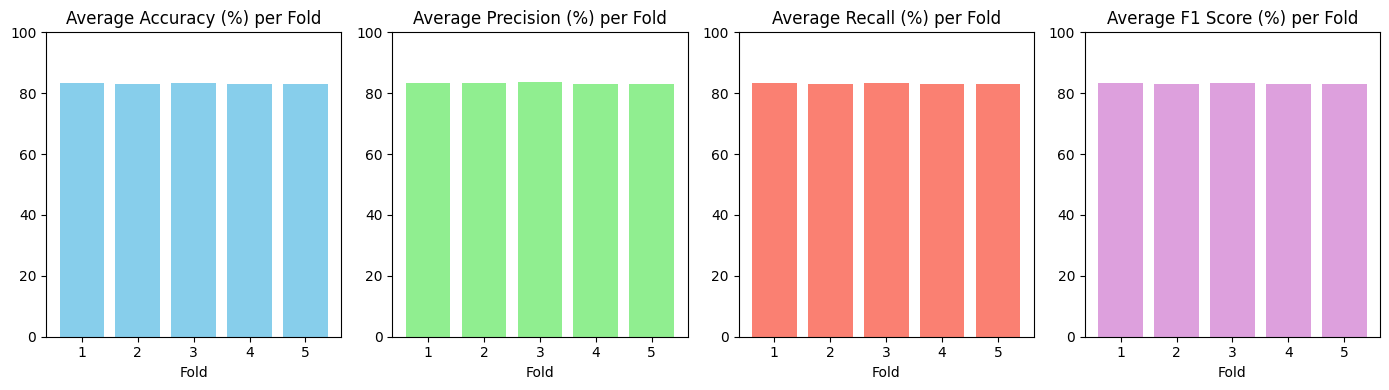


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     83.20       83.20       83.20       83.20       
2     83.11       83.22       83.11       83.09       
3     83.51       83.53       83.51       83.51       
4     82.88       82.93       82.88       82.88       
5     83.12       83.13       83.12       83.12       


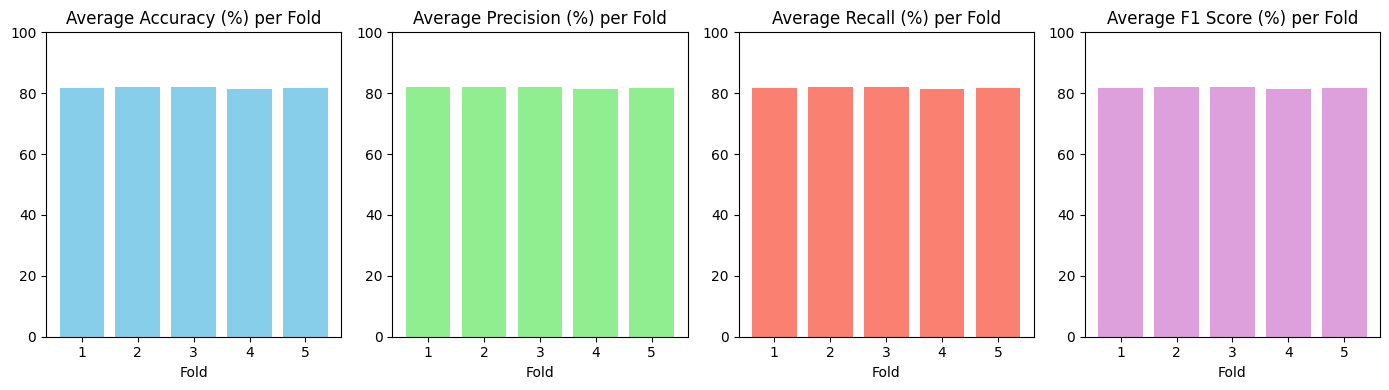


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.81       81.93       81.81       81.79       
2     81.89       81.92       81.89       81.89       
3     82.12       82.20       82.12       82.11       
4     81.30       81.32       81.30       81.29       
5     81.75       81.77       81.75       81.74       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_per_fold(best_fold_results_custom_model)

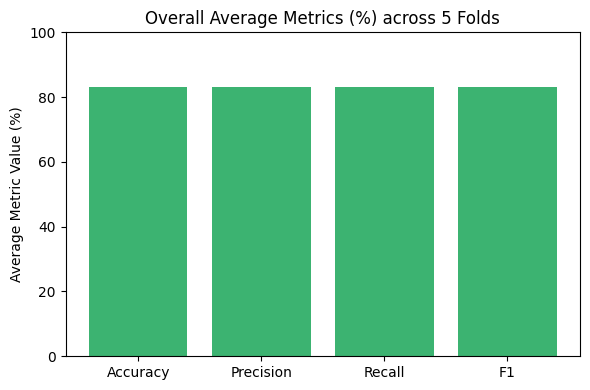


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         83.16
Precision        83.20
Recall           83.16
F1               83.16


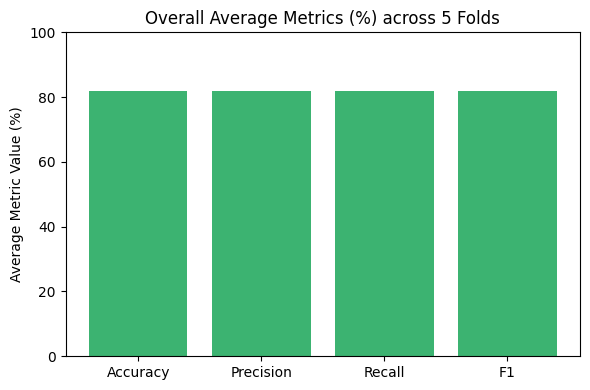


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.77
Precision        81.83
Recall           81.77
F1               81.77


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_across_folds(best_fold_results_custom_model)

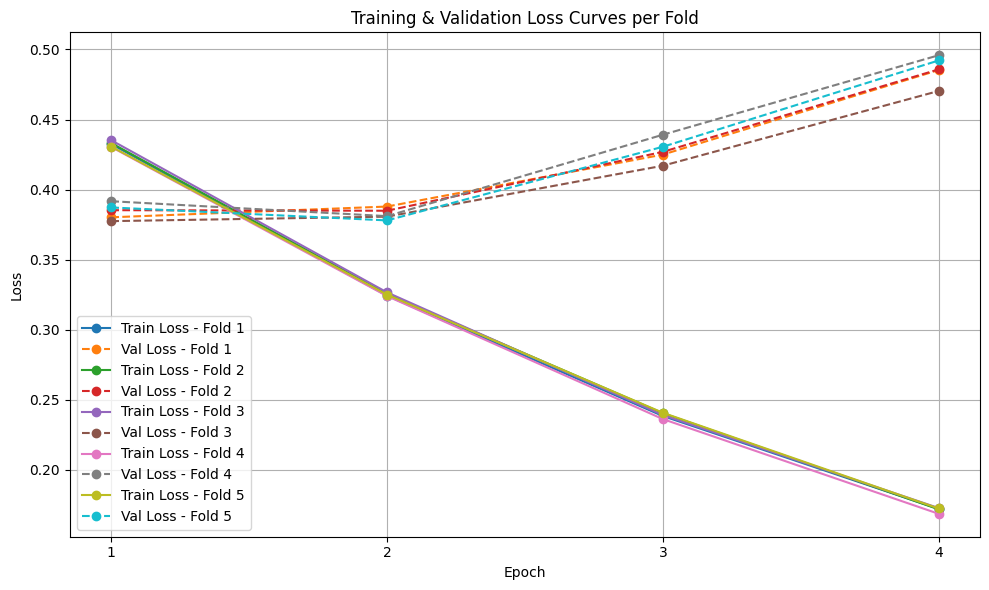


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4325         0.3802         
1     2       0.3243         0.3879         
1     3       0.2384         0.4250         
1     4       0.1721         0.4853         
--------------------------------------------------
2     1       0.4332         0.3853         
2     2       0.3255         0.3849         
2     3       0.2404         0.4269         
2     4       0.1718         0.4858         
--------------------------------------------------
3     1       0.4352         0.3775         
3     2       0.3266         0.3807         
3     3       0.2391         0.4170         
3     4       0.1727         0.4704         
--------------------------------------------------
4     1       0.4304         0.3917         
4     2       0.3240         0.3810         
4     3       0.2362         0.4391  

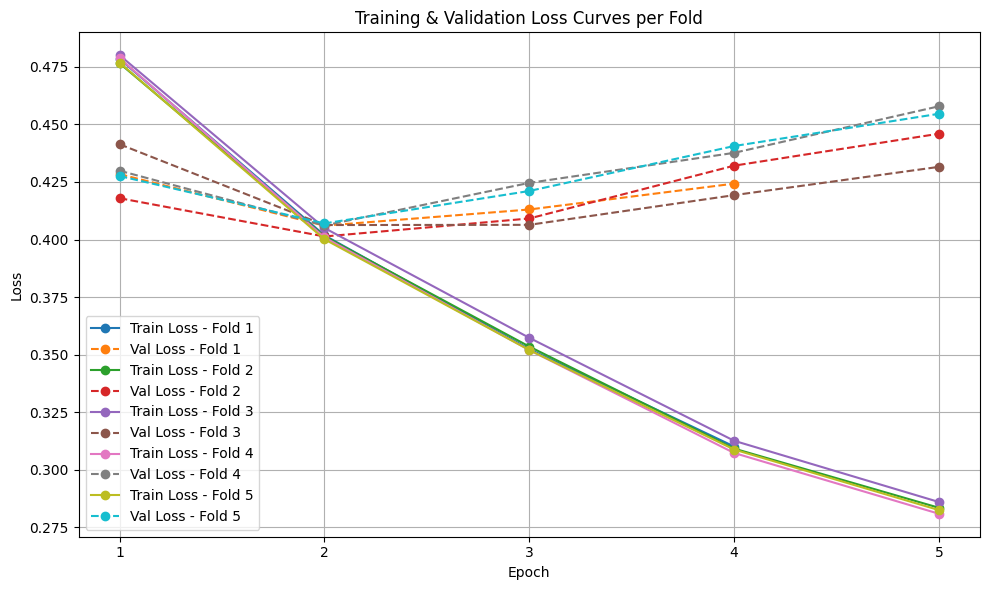


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4784         0.4284         
1     2       0.4018         0.4060         
1     3       0.3524         0.4130         
1     4       0.3101         0.4243         
--------------------------------------------------
2     1       0.4765         0.4179         
2     2       0.4014         0.4013         
2     3       0.3535         0.4091         
2     4       0.3092         0.4321         
2     5       0.2835         0.4459         
--------------------------------------------------
3     1       0.4800         0.4413         
3     2       0.4050         0.4063         
3     3       0.3573         0.4064         
3     4       0.3126         0.4193         
3     5       0.2860         0.4315         
--------------------------------------------------
4     1       0.4787         0.4299  

,Fold,Epoch,Train Loss,Validation Loss
0,1,1,0.4784,0.428378
1,1,2,0.4018,0.406009
2,1,3,0.3524,0.413033
3,1,4,0.3101,0.424262
4,2,1,0.4765,0.417929
5,2,2,0.4014,0.401316
6,2,3,0.3535,0.409129
7,2,4,0.3092,0.432064
8,2,5,0.2835,0.445939
9,3,1,0.4800,0.441346


In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(best_fold_results_pretrained_model)
plot_loss_per_fold(best_fold_results_custom_model)

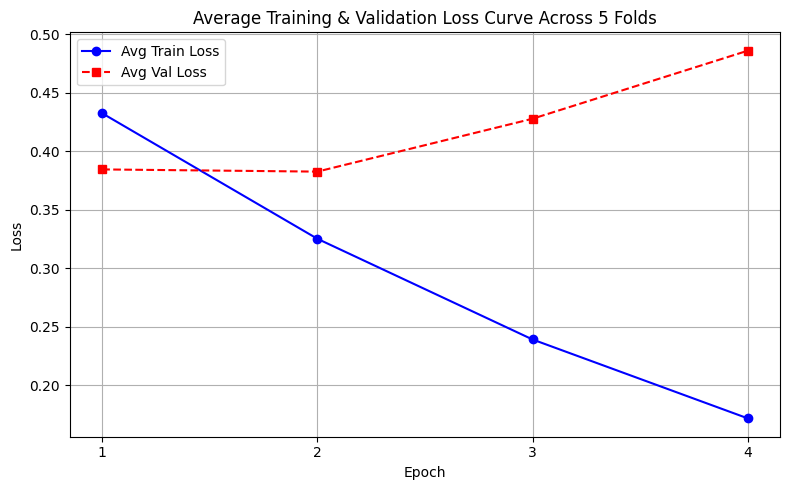


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4324          0.3844          
2       0.3251          0.3825          
3       0.2390          0.4277          
4       0.1715          0.4859          


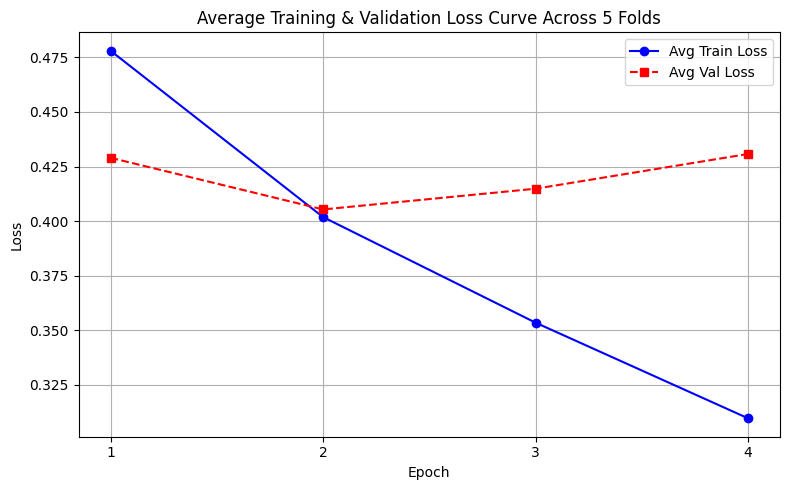


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4781          0.4290          
2       0.4018          0.4053          
3       0.3534          0.4148          
4       0.3096          0.4308          


,Epoch,Avg Train Loss,Avg Validation Loss
0,1,0.47808,0.429013
1,2,0.40184,0.405338
2,3,0.35344,0.414838
3,4,0.30960,0.430762


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(best_fold_results_pretrained_model)
plot_avg_loss_across_folds(best_fold_results_custom_model)

---
# **4.2 Final Model Training**

## Define Best Final Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_final_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="no",              # No evaluation during training
        save_strategy="no",              # Do not save at each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_final_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_best_training_args(best_params1, model_loader)
tuned_final_pretrained_trainer, tuned_final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
625,0.424300
1250,0.320400
1875,0.235500
2500,0.171700
3125,0.141200


In [ ]:
# Train on the full training set (already tokenized)
best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)
training_args = create_best_training_args(best_params2, best_model_loader)
tuned_final_custom_trainer, tuned_final_custom_model = train_final_model(full_train_dataset, training_args, best_model_loader)

<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
2500,0.468100
5000,0.396900
7500,0.349200
10000,0.306600
12500,0.279500


---
# **4.3 Final Model Evaluation**

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8320 (83.20%)
Precision      0.8321 (83.21%)
Recall         0.8320 (83.20%)
F1 Score       0.8320 (83.20%)
Loss           0.5221
--------------------------------------------------


{'eval_loss': 0.5220932960510254,
 'eval_accuracy': 0.832,
 'eval_precision': 0.8320937301343933,
 'eval_recall': 0.832,
 'eval_f1': 0.8319881450835171,
 'eval_runtime': 8.0772,
 'eval_samples_per_second': 2476.107,
 'eval_steps_per_second': 77.378,
 'epoch': 5.0}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(tuned_final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8230 (82.30%)
Precision      0.8234 (82.34%)
Recall         0.8230 (82.30%)
F1 Score       0.8230 (82.30%)
Loss           0.4411
--------------------------------------------------


{'eval_loss': 0.44113707542419434,
 'eval_accuracy': 0.82305,
 'eval_precision': 0.8233708647405389,
 'eval_recall': 0.82305,
 'eval_f1': 0.8230060944493043,
 'eval_runtime': 8.0973,
 'eval_samples_per_second': 2469.971,
 'eval_steps_per_second': 77.187,
 'epoch': 5.0}

---
# **4.4 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8320 (83.20%)
Precision      0.8321 (83.21%)
Recall         0.8320 (83.20%)
F1 Score       0.8320 (83.20%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8265    0.8404    0.8334     10000
    Positive     0.8377    0.8236    0.8306     10000

    accuracy                         0.8320     20000
   macro avg     0.8321    0.8320    0.8320     20000
weighted avg     0.8321    0.8320    0.8320     20000


Confusion Matrix:
[[8404 1596]
 [1764 8236]]

Confusion matrix saved to ./2_Fine_Tuned_Pretrained_Model_Raw_Tweets/confusion_matrix.png



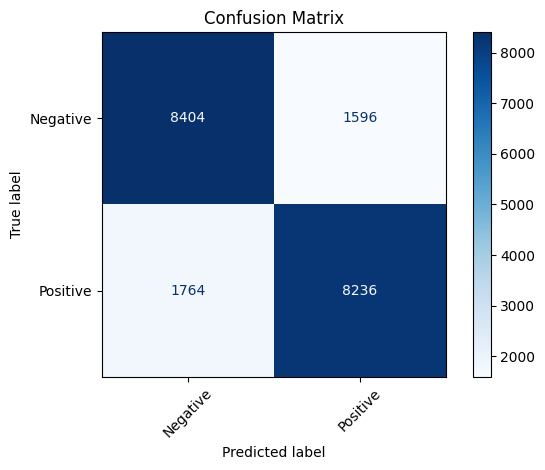

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Raw_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8230 (82.30%)
Precision      0.8234 (82.34%)
Recall         0.8230 (82.30%)
F1 Score       0.8230 (82.30%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8132    0.8388    0.8258     10000
    Positive     0.8336    0.8073    0.8202     10000

    accuracy                         0.8230     20000
   macro avg     0.8234    0.8231    0.8230     20000
weighted avg     0.8234    0.8230    0.8230     20000


Confusion Matrix:
[[8388 1612]
 [1927 8073]]

Confusion matrix saved to ./2_Fine_Tuned_Custom_Model_Raw_Tweets/confusion_matrix.png



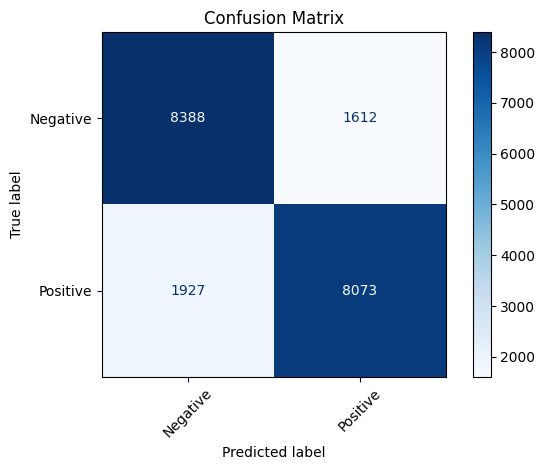

In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Raw_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **4.5 Save Final Model**

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Raw_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)
metrics3 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_pretrained_model, tokenizer, model_name, metrics=metrics3)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8320 (83.20%)
Precision      0.8321 (83.21%)
Recall         0.8320 (83.20%)
F1 Score       0.8320 (83.20%)
Loss           0.5221
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Pretrained_Model_Raw_Tweets


In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Raw_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_custom_trainer, test_dataset)
metrics4 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_custom_model, tokenizer, model_name, metrics=metrics4)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8230 (82.30%)
Precision      0.8234 (82.34%)
Recall         0.8230 (82.30%)
F1 Score       0.8230 (82.30%)
Loss           0.4411
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Custom_Model_Raw_Tweets
